<a href="https://colab.research.google.com/github/DawnSpider96/L361-Federated-Learning/blob/release/Copy_of_L361_2025_Lab_1_From_Centralised_To_Federated_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies
---


In [1]:
# `pip` could produce some errors. Do not worry about them.
# The execution has been verified; it's working anyway.
# ! pip install --quiet --upgrade "pip"
# ! pip install --quiet matplotlib tqdm seaborn
# ! pip install git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching \
#     torch torchvision ray=="2.6.3"

### Imports.


In [2]:
import sys
sys.path.append('../../')
print(sys.path)

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/dawn/venvs/fed/lib/python3.10/site-packages', '/home/dawn/repos/cycle-consistent-model-merging/src', '/home/dawn/repos/c2m3-federated', '/home/dawn/repos/c2m3-fed', '../../']


In [3]:
import random
from pathlib import Path
import tarfile
from typing import Any
from logging import INFO
from collections import defaultdict, OrderedDict
from collections.abc import Sequence, Callable
import numbers

import numpy as np
import torch
from torch import nn
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from enum import IntEnum
import flwr
from flwr.server import History, ServerConfig
from flwr.server.strategy import FedAvgM as FedAvg, Strategy
from c2m3.flower.fed_frank_wolfe_strategy import FrankWolfeSync
from flwr.common import log, NDArrays, Scalar, Parameters, ndarrays_to_parameters
from flwr.client.client import Client

from c2m3.common.client_utils import (
    Net,
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator,
    train_femnist,
    test_femnist,
    save_history,
    get_model_parameters,
    set_model_parameters
)


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    """Seeds for reproducibility."""

    DEFAULT = 101 # [42, 123, 456, 789, 101]


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


PathType = Path | str | None


def get_device() -> str:
    """Get the device (cuda, mps, cpu)."""
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    return device

/home/dawn/venvs/fed/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-28 01:43:59.585946: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-28 01:43:59.679499: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-28 01:43:59.680603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-28 01:44:01.184164: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-03-28 01:44:03,739	INFO util.py:

In [4]:
home_dir = Path.cwd() / ".."
dataset_dir: Path = home_dir / "data" / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_iid"
# Decompress dataset
# if not dataset_dir.exists():
#     with tarfile.open(home_dir / "femnist.tar.gz", "r:gz") as tar:
#         tar.extractall(path=home_dir)
#     log(INFO, "Dataset extracted in %s", dataset_dir)

## Build Flower FL client.
---

In [5]:
class FlowerRayClient(flwr.client.NumPyClient):
    """Flower client for the FEMNIST dataset."""

    def __init__(
        self,
        cid: int,
        partition_dir: Path,
        model_generator: Callable[[], Module],
    ) -> None:
        """Init the client with its unique id and the folder to load data from.

        Parameters
        ----------
            cid (int): Unique client id for a client used to map it to its data
                partition
            partition_dir (Path): The directory containing data for each
                client/client id
            model_generator (Callable[[], Module]): The model generator function
        """
        self.cid = cid
        log(INFO, "cid: %s", self.cid)
        self.partition_dir = partition_dir
        self.device = str(
            torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        )
        self.model_generator: Callable[[], Module] = model_generator
        self.properties: dict[str, Scalar] = {
            "tensor_type": "numpy.ndarray",
            "partition": self.partition_dir,
            "cid": self.cid
            }
        self.data_dir = data_dir

    def set_parameters(self, parameters: NDArrays) -> Module:
        """Load weights inside the network.

        Parameters
        ----------
            parameters (NDArrays): set of weights to be loaded.

        Returns
        -------
            [Module]: Network with new set of weights.
        """
        net = self.model_generator()
        return set_model_parameters(net, parameters)

    def get_parameters(self, config: dict[str, Scalar]) -> NDArrays:
        """Return weights from a given model.

        If no model is passed, then a local model is created.
        This can be used to initialise a model in the
        server.
        The config param is not used but is mandatory in Flower.

        Parameters
        ----------
            config (dict[int, Scalar]): dictionary containing configuration info.

        Returns
        -------
            NDArrays: weights from the model.
        """
        net = self.model_generator()
        return get_model_parameters(net)

    def fit(
        self, parameters: NDArrays, config: dict[str, Scalar]
    ) -> tuple[NDArrays, int, dict]:
        """Receive and train a model on the local client data.

        It uses parameters from the config dict

        Parameters
        ----------
            net (NDArrays): Pytorch model parameters
            config (dict[str, Scalar]): dictionary describing the training parameters

        Returns
        -------
            tuple[NDArrays, int, dict]: Returns the updated model, the size of the local
                dataset and other metrics
        """
        # Only create model right before training/testing
        # To lower memory usage when idle
        net = self.set_parameters(parameters)
        net.to(self.device)

        train_loader: DataLoader = self._create_data_loader(config, name="train")
        train_loss = self._train(net, train_loader=train_loader, config=config)
        return get_model_parameters(net), len(train_loader), {"train_loss": train_loss}

    def evaluate(
        self, parameters: NDArrays, config: dict[str, Scalar]
    ) -> tuple[float, int, dict]:
        """Receive and test a model on the local client data.

        It uses parameters from the config dict

        Parameters
        ----------
            net (NDArrays): Pytorch model parameters
            config (dict[str, Scalar]): dictionary describing the testing parameters

        Returns
        -------
            tuple[float, int, dict]: Returns the loss accumulate during testing, the
                size of the local dataset and other metrics such as accuracy
        """
        net = self.set_parameters(parameters)
        net.to(self.device)

        test_loader: DataLoader = self._create_data_loader(config, name="test")
        loss, accuracy = self._test(net, test_loader=test_loader, config=config)
        return loss, len(test_loader), {"local_accuracy": accuracy}

    def _create_data_loader(self, config: dict[str, Scalar], name: str) -> DataLoader:
        """Create the data loader using the specified config parameters.

        Parameters
        ----------
            config (dict[str, Scalar]): dictionary containing dataloader and dataset
                parameters
            mode (str): Load the training or testing set for the client

        Returns
        -------
            DataLoader: A pytorch dataloader iterable for training/testing
        """
        batch_size = int(config["batch_size"])
        num_workers = int(config["num_workers"])
        dataset = self._load_dataset(name)
        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            drop_last=(name == "train"),
        )

    def _load_dataset(self, name: str) -> Dataset:
        full_file: Path = self.partition_dir / str(self.cid)
        return load_femnist_dataset(
            mapping=full_file,
            name=name,
            data_dir=data_dir,
        )

    def _train(
        self, net: Module, train_loader: DataLoader, config: dict[str, Scalar]
    ) -> float:
        return train_femnist(
            net=net,
            train_loader=train_loader,
            epochs=int(config["epochs"]),
            device=self.device,
            optimizer=torch.optim.AdamW(
                net.parameters(),
                lr=float(config["client_learning_rate"]),
                weight_decay=float(config["weight_decay"]),
            ),
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=int(config["max_batches"]),
        )

    def _test(
        self, net: Module, test_loader: DataLoader, config: dict[str, Scalar]
    ) -> tuple[float, float]:
        return test_femnist(
            net=net,
            test_loader=test_loader,
            device=self.device,
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=int(config["max_batches"]),
        )

    def get_properties(self, config: dict[str, Scalar]) -> dict[str, Scalar]:
        """Return properties for this client.

        Parameters
        ----------
            config (dict[str, Scalar]): Options to be used for selecting specific
            properties.

        Returns
        -------
            dict[str, Scalar]: Returned properties.
        """
        return self.properties

    def get_train_set_size(self) -> int:
        """Return the client train set size.

        Returns
        -------
            int: train set size of the client.
        """
        return len(self._load_dataset("train"))  # type: ignore[reportArgumentType]

    def get_test_set_size(self) -> int:
        """Return the client test set size.

        Returns
        -------
            int: test set size of the client.
        """
        return len(self._load_dataset("test"))  # type: ignore[reportArgumentType]


# def fit_client_seeded(
#     client: FlowerRayClient,
#     params: NDArrays,
#     conf: dict[str, Any],
#     seed: Seeds = Seeds.DEFAULT,
#     **kwargs: Any,
# ) -> tuple[NDArrays, int, dict]:
#     """Wrap to always seed client training."""
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     random.seed(seed)
#     return client.fit(params, conf, **kwargs)

In [6]:
def get_flower_client_generator(
    model_generator: Callable[[], Module],
    partition_dir: Path,
    mapping_fn: Callable[[int], int] | None = None,
) -> Callable[[str], FlowerRayClient]:
    """Wrap the client instance generator.

    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Parameters
    ----------
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered
            ids to real cid.

    Returns
    -------
        Callable[[str], FlowerRayClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerRayClient:
        """Create a single client instance given the client id `cid`.

        Parameters
        ----------
            cid (str): client id, Flower requires this to be of type str.

        Returns
        -------
            FlowerRayClient: client instance.
        """
        return FlowerRayClient(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            partition_dir=partition_dir,
            model_generator=model_generator,
        )

    return client_fn

In [7]:
network_generator = get_network_generator()
seed_net: Net = network_generator()
seed_model_params: NDArrays = get_model_parameters(seed_net)

centralized_flower_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(network_generator, centralized_partition)
)
centralized_flower_client = centralized_flower_client_generator(str(0))

INFO flwr 2025-03-28 01:44:07,321 | 3963006861.py:21 | cid: 0


2025-03-28 01:44:07 INFO     cid: 0                                                                         ]8;id=376097;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=489830;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

In [8]:
seed_net

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=62, bias=True)
)

In [9]:
seed_net.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.1208, -0.0199, -0.1636,  0.1549, -0.0842],
                        [-0.1926,  0.1638, -0.0638, -0.0276,  0.0930],
                        [-0.0090, -0.1713,  0.0333,  0.1008,  0.1060],
                        [-0.1423,  0.0861, -0.0419,  0.0497, -0.0527],
                        [ 0.1529, -0.0502, -0.1417, -0.0532,  0.0258]]],
              
              
                      [[[ 0.0109, -0.1544, -0.1603, -0.1345,  0.1075],
                        [-0.0070,  0.1208, -0.0433, -0.0690,  0.0034],
                        [-0.0618,  0.0489,  0.0278,  0.0869, -0.1005],
                        [-0.0246,  0.1286,  0.0296,  0.0830, -0.0352],
                        [ 0.1459, -0.0822,  0.0518,  0.1455, -0.0251]]],
              
              
                      [[[ 0.0182, -0.0905, -0.0839, -0.0534, -0.1320],
                        [-0.1714, -0.1545,  0.1824,  0.0969, -0.0934],
                        [ 0.1069,  0.0191,  0.1310, -0

In [10]:
def sample_random_clients(
    total_clients: int,
    filter_less: int,
    partition: Path,
    seed: int | None = Seeds.DEFAULT,
) -> Sequence[int]:
    """Sample randomly clients.

    A filter on the client train set size is performed.

    Parameters
    ----------
        total_clients (int): total number of clients to sample.
        filter_less (int): max number of train samples for which the client is
            **discarded**.
        partition (Path): path to the folder containing the partitioning.
        seed (Optional[int], optional): seed for the random generator. Defaults to None.

    Returns
    -------
        Sequence[int]: list of sample client ids as int.
    """
    real_federated_cid_client_generator: Callable[[str], FlowerRayClient] = (
        get_flower_client_generator(network_generator, federated_partition)
    )
    if seed is not None:
        random.seed(seed)
    list_of_ids = []
    while len(list_of_ids) < total_clients:
        current_id = random.randint(0, 619)
        if (
            real_federated_cid_client_generator(str(current_id)).get_train_set_size()
            > filter_less
        ):
            list_of_ids.append(current_id)
    return list_of_ids

While FEMNIST has more than 3000 clients, our small-scale experiments will not require more than 100 at any point.

In [11]:
total_clients: int = 100
list_of_ids = sample_random_clients(
    total_clients, 32, federated_partition
)

federated_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(
        network_generator, federated_partition, lambda seq_id: list_of_ids[seq_id]
    )
)

INFO flwr 2025-03-28 01:44:07,410 | 3963006861.py:21 | cid: 595


                    INFO     cid: 595                                                                       ]8;id=968859;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=376097;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,418 | 3963006861.py:21 | cid: 478


                    INFO     cid: 478                                                                       ]8;id=631287;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=232465;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,426 | 3963006861.py:21 | cid: 295


                    INFO     cid: 295                                                                       ]8;id=345020;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=459257;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,432 | 3963006861.py:21 | cid: 72


                    INFO     cid: 72                                                                        ]8;id=466838;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=807290;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,438 | 3963006861.py:21 | cid: 550


                    INFO     cid: 550                                                                       ]8;id=341865;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=250421;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,445 | 3963006861.py:21 | cid: 413


                    INFO     cid: 413                                                                       ]8;id=490435;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=319070;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,452 | 3963006861.py:21 | cid: 216


                    INFO     cid: 216                                                                       ]8;id=713185;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=344490;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,459 | 3963006861.py:21 | cid: 273


                    INFO     cid: 273                                                                       ]8;id=443513;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=80571;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,469 | 3963006861.py:21 | cid: 414


                    INFO     cid: 414                                                                       ]8;id=914178;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=486649;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,477 | 3963006861.py:21 | cid: 221


                    INFO     cid: 221                                                                       ]8;id=22928;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=388921;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,486 | 3963006861.py:21 | cid: 368


                    INFO     cid: 368                                                                       ]8;id=160816;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=36262;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,495 | 3963006861.py:21 | cid: 442


                    INFO     cid: 442                                                                       ]8;id=158081;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=424332;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,500 | 3963006861.py:21 | cid: 371


                    INFO     cid: 371                                                                       ]8;id=174410;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=522664;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,506 | 3963006861.py:21 | cid: 522


                    INFO     cid: 522                                                                       ]8;id=724650;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=556348;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,513 | 3963006861.py:21 | cid: 6


                    INFO     cid: 6                                                                         ]8;id=362561;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=560138;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,519 | 3963006861.py:21 | cid: 452


                    INFO     cid: 452                                                                       ]8;id=740005;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=639496;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,525 | 3963006861.py:21 | cid: 619


                    INFO     cid: 619                                                                       ]8;id=147131;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=719080;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,531 | 3963006861.py:21 | cid: 183


                    INFO     cid: 183                                                                       ]8;id=978237;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=935801;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,539 | 3963006861.py:21 | cid: 560


                    INFO     cid: 560                                                                       ]8;id=157271;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=927439;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,546 | 3963006861.py:21 | cid: 319


                    INFO     cid: 319                                                                       ]8;id=575182;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=577066;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,554 | 3963006861.py:21 | cid: 358


                    INFO     cid: 358                                                                       ]8;id=712050;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=864552;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,562 | 3963006861.py:21 | cid: 335


                    INFO     cid: 335                                                                       ]8;id=262163;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=488762;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,570 | 3963006861.py:21 | cid: 209


                    INFO     cid: 209                                                                       ]8;id=944819;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=334658;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,580 | 3963006861.py:21 | cid: 250


                    INFO     cid: 250                                                                       ]8;id=184596;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=12699;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,589 | 3963006861.py:21 | cid: 14


                    INFO     cid: 14                                                                        ]8;id=481107;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=687803;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,599 | 3963006861.py:21 | cid: 583


                    INFO     cid: 583                                                                       ]8;id=829265;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=286519;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,605 | 3963006861.py:21 | cid: 482


                    INFO     cid: 482                                                                       ]8;id=561352;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=330681;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,614 | 3963006861.py:21 | cid: 342


                    INFO     cid: 342                                                                       ]8;id=362329;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=711862;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,620 | 3963006861.py:21 | cid: 373


                    INFO     cid: 373                                                                       ]8;id=56971;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=781217;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,629 | 3963006861.py:21 | cid: 225


                    INFO     cid: 225                                                                       ]8;id=697224;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=126295;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,637 | 3963006861.py:21 | cid: 149


                    INFO     cid: 149                                                                       ]8;id=469115;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=901968;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,646 | 3963006861.py:21 | cid: 207


                    INFO     cid: 207                                                                       ]8;id=382050;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=538086;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,651 | 3963006861.py:21 | cid: 563


                    INFO     cid: 563                                                                       ]8;id=583122;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=333813;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,656 | 3963006861.py:21 | cid: 307


                    INFO     cid: 307                                                                       ]8;id=252415;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=924965;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,662 | 3963006861.py:21 | cid: 445


                    INFO     cid: 445                                                                       ]8;id=42473;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=258030;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,669 | 3963006861.py:21 | cid: 50


                    INFO     cid: 50                                                                        ]8;id=460074;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=459819;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,677 | 3963006861.py:21 | cid: 52


                    INFO     cid: 52                                                                        ]8;id=997019;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=35326;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,683 | 3963006861.py:21 | cid: 476


                    INFO     cid: 476                                                                       ]8;id=13885;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=431821;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,688 | 3963006861.py:21 | cid: 462


                    INFO     cid: 462                                                                       ]8;id=150417;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=511071;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,693 | 3963006861.py:21 | cid: 63


                    INFO     cid: 63                                                                        ]8;id=633819;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=669274;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,702 | 3963006861.py:21 | cid: 124


                    INFO     cid: 124                                                                       ]8;id=471554;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=355427;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,707 | 3963006861.py:21 | cid: 532


                    INFO     cid: 532                                                                       ]8;id=748292;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=437410;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,716 | 3963006861.py:21 | cid: 111


                    INFO     cid: 111                                                                       ]8;id=227306;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=675543;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,721 | 3963006861.py:21 | cid: 544


                    INFO     cid: 544                                                                       ]8;id=682878;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=165732;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,730 | 3963006861.py:21 | cid: 176


                    INFO     cid: 176                                                                       ]8;id=697086;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=775185;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,737 | 3963006861.py:21 | cid: 196


                    INFO     cid: 196                                                                       ]8;id=939721;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=541647;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,745 | 3963006861.py:21 | cid: 523


                    INFO     cid: 523                                                                       ]8;id=553127;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=980142;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,754 | 3963006861.py:21 | cid: 12


                    INFO     cid: 12                                                                        ]8;id=947713;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=134346;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,760 | 3963006861.py:21 | cid: 590


                    INFO     cid: 590                                                                       ]8;id=115011;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=115852;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,769 | 3963006861.py:21 | cid: 41


                    INFO     cid: 41                                                                        ]8;id=915828;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=643017;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,775 | 3963006861.py:21 | cid: 616


                    INFO     cid: 616                                                                       ]8;id=140416;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=734028;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,780 | 3963006861.py:21 | cid: 61


                    INFO     cid: 61                                                                        ]8;id=64817;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=100974;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,786 | 3963006861.py:21 | cid: 304


                    INFO     cid: 304                                                                       ]8;id=868132;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=407287;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,793 | 3963006861.py:21 | cid: 571


                    INFO     cid: 571                                                                       ]8;id=920490;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=964023;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,801 | 3963006861.py:21 | cid: 340


                    INFO     cid: 340                                                                       ]8;id=408206;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=941432;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,807 | 3963006861.py:21 | cid: 247


                    INFO     cid: 247                                                                       ]8;id=158522;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=627350;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,817 | 3963006861.py:21 | cid: 168


                    INFO     cid: 168                                                                       ]8;id=203121;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=926832;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,826 | 3963006861.py:21 | cid: 280


                    INFO     cid: 280                                                                       ]8;id=200131;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=345201;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,834 | 3963006861.py:21 | cid: 39


                    INFO     cid: 39                                                                        ]8;id=35110;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=792802;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,842 | 3963006861.py:21 | cid: 384


                    INFO     cid: 384                                                                       ]8;id=694384;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=757908;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,853 | 3963006861.py:21 | cid: 378


                    INFO     cid: 378                                                                       ]8;id=480365;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=647066;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,865 | 3963006861.py:21 | cid: 270


                    INFO     cid: 270                                                                       ]8;id=316481;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=95921;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,875 | 3963006861.py:21 | cid: 180


                    INFO     cid: 180                                                                       ]8;id=895975;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=46873;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,884 | 3963006861.py:21 | cid: 393


                    INFO     cid: 393                                                                       ]8;id=2714;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=398340;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,898 | 3963006861.py:21 | cid: 128


                    INFO     cid: 128                                                                       ]8;id=961331;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=769803;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,906 | 3963006861.py:21 | cid: 190


                    INFO     cid: 190                                                                       ]8;id=781577;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=762239;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,915 | 3963006861.py:21 | cid: 448


                    INFO     cid: 448                                                                       ]8;id=224920;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=717574;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,924 | 3963006861.py:21 | cid: 610


                    INFO     cid: 610                                                                       ]8;id=794679;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=172261;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,935 | 3963006861.py:21 | cid: 528


                    INFO     cid: 528                                                                       ]8;id=242429;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=440901;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,946 | 3963006861.py:21 | cid: 538


                    INFO     cid: 538                                                                       ]8;id=747635;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=742391;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,957 | 3963006861.py:21 | cid: 10


                    INFO     cid: 10                                                                        ]8;id=479092;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=656054;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,968 | 3963006861.py:21 | cid: 381


                    INFO     cid: 381                                                                       ]8;id=989615;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=503275;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,975 | 3963006861.py:21 | cid: 248


                    INFO     cid: 248                                                                       ]8;id=778837;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=67073;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,983 | 3963006861.py:21 | cid: 397


                    INFO     cid: 397                                                                       ]8;id=102272;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=567591;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,989 | 3963006861.py:21 | cid: 62


                    INFO     cid: 62                                                                        ]8;id=854019;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=362533;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:07,998 | 3963006861.py:21 | cid: 391


                    INFO     cid: 391                                                                       ]8;id=822306;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=245039;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,006 | 3963006861.py:21 | cid: 551


2025-03-28 01:44:08 INFO     cid: 551                                                                       ]8;id=438875;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=799978;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,012 | 3963006861.py:21 | cid: 177


                    INFO     cid: 177                                                                       ]8;id=777198;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=875403;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,020 | 3963006861.py:21 | cid: 598


                    INFO     cid: 598                                                                       ]8;id=860052;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=750799;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,026 | 3963006861.py:21 | cid: 162


                    INFO     cid: 162                                                                       ]8;id=301244;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=554817;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,035 | 3963006861.py:21 | cid: 580


                    INFO     cid: 580                                                                       ]8;id=579182;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=590547;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,044 | 3963006861.py:21 | cid: 89


                    INFO     cid: 89                                                                        ]8;id=196829;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=866619;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,053 | 3963006861.py:21 | cid: 487


                    INFO     cid: 487                                                                       ]8;id=524132;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=319818;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,063 | 3963006861.py:21 | cid: 188


                    INFO     cid: 188                                                                       ]8;id=445253;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=504327;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,069 | 3963006861.py:21 | cid: 60


                    INFO     cid: 60                                                                        ]8;id=78278;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=597126;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,077 | 3963006861.py:21 | cid: 256


                    INFO     cid: 256                                                                       ]8;id=337731;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=39284;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,084 | 3963006861.py:21 | cid: 158


                    INFO     cid: 158                                                                       ]8;id=664374;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=167055;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,089 | 3963006861.py:21 | cid: 419


                    INFO     cid: 419                                                                       ]8;id=336088;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=153962;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,097 | 3963006861.py:21 | cid: 594


                    INFO     cid: 594                                                                       ]8;id=895082;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=729592;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,104 | 3963006861.py:21 | cid: 393


                    INFO     cid: 393                                                                       ]8;id=308726;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=299649;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,110 | 3963006861.py:21 | cid: 528


                    INFO     cid: 528                                                                       ]8;id=692484;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=961008;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,114 | 3963006861.py:21 | cid: 149


                    INFO     cid: 149                                                                       ]8;id=553404;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=456943;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,119 | 3963006861.py:21 | cid: 184


                    INFO     cid: 184                                                                       ]8;id=970234;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=605767;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,125 | 3963006861.py:21 | cid: 214


                    INFO     cid: 214                                                                       ]8;id=944364;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=713742;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,131 | 3963006861.py:21 | cid: 405


                    INFO     cid: 405                                                                       ]8;id=183996;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=648170;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,137 | 3963006861.py:21 | cid: 131


                    INFO     cid: 131                                                                       ]8;id=63952;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=967210;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,146 | 3963006861.py:21 | cid: 362


                    INFO     cid: 362                                                                       ]8;id=214838;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=827113;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,153 | 3963006861.py:21 | cid: 569


                    INFO     cid: 569                                                                       ]8;id=820483;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=478;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,159 | 3963006861.py:21 | cid: 176


                    INFO     cid: 176                                                                       ]8;id=751742;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=528602;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:08,165 | 3963006861.py:21 | cid: 205


                    INFO     cid: 205                                                                       ]8;id=874178;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=730528;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Now, to test that the newly partitioned clients can be trained.

In [12]:
test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

In [13]:
# num_clients = 4
# clientIds = random.sample(list(range(total_clients)), num_clients)
# clients = [federated_client_generator(str(cid)) for cid in clientIds]
# print(f'{clients=}')

In [14]:
def get_federated_evaluation_function(
    batch_size: int,
    num_workers: int,
    model_generator: Callable[[], Module],
    criterion: Module,
    max_batches: int,
) -> Callable[[int, NDArrays, dict[str, Any]], tuple[float, dict[str, Scalar]]]:
    """Wrap the external federated evaluation function.

    It provides the external federated evaluation function with some
    parameters for the dataloader, the model generator function, and
    the criterion used in the evaluation.

    Parameters
    ----------
        batch_size (int): batch size of the test set to use.
        num_workers (int): correspond to `num_workers` param in the Dataloader object.
        model_generator (Callable[[], Module]):  model generator function.
        criterion (Module): PyTorch Module containing the criterion for evaluating the
        model.

    Returns
    -------
        Callable[[int, NDArrays, dict[str, Any]], tuple[float, dict[str, Scalar]]]:
            external federated evaluation function.
    """

    def federated_evaluation_function(
        server_round: int,
        parameters: NDArrays,
        fed_eval_config: dict[
            str, Any
        ],  # mandatory argument, even if it's not being used
    ) -> tuple[float, dict[str, Scalar]]:
        """Evaluate federated model on the server.

        It uses the centralized val set for sake of simplicity.

        Parameters
        ----------
            server_round (int): current federated round.
            parameters (NDArrays): current model parameters.
            fed_eval_config (dict[str, Any]): mandatory argument in Flower, can contain
                some configuration info

        Returns
        -------
            tuple[float, dict[str, Scalar]]: evaluation results
        """
        device: str = get_device()
        net: Module = set_model_parameters(model_generator(), parameters)
        net.to(device)

        full_file: Path = centralized_mapping
        dataset: Dataset = load_femnist_dataset(data_dir, full_file, "val")

        valid_loader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            drop_last=False,
        )

        loss, acc = test_femnist(
            net=net,
            test_loader=valid_loader,
            device=device,
            criterion=criterion,
            max_batches=max_batches,
        )
        return loss, {"accuracy": acc}

    return federated_evaluation_function


federated_evaluation_function = get_federated_evaluation_function(
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator,
    criterion=nn.CrossEntropyLoss(),
    max_batches=test_config["max_batches"],
)

In [15]:
def aggregate_weighted_average(metrics: list[tuple[int, dict]]) -> dict:
    """Combine results from multiple clients following training or evaluation.

    Parameters
    ----------
        metrics (list[tuple[int, dict]]): collected clients metrics

    Returns
    -------
        dict: result dictionary containing the aggregate of the metrics passed.
    """
    average_dict: dict = defaultdict(list)
    total_examples: int = 0
    for num_examples, metrics_dict in metrics:
        for key, val in metrics_dict.items():
            if isinstance(val, numbers.Number):
                average_dict[key].append((num_examples, val))
        total_examples += num_examples
    return {
        key: {
            "avg": float(
                sum([num_examples * metric for num_examples, metric in val])
                / float(total_examples)
            ),
            "all": val,
        }
        for key, val in average_dict.items()
    }

In [16]:
# Federated configuration dictionary
federated_train_config: dict[str, Any] = {
    "epochs": 25,
    "batch_size": 32,
    "client_learning_rate": 0.001,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
    "central_dir": home_dir / "data" / "femnist" / "client_data_mappings" / "centralized" / "0"
}

FL SIMULATION

In [17]:
def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    return_all_parameters: bool = False,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap to seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = flwr.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(home_dir, hist, name)
    return parameter_list, hist

`run_simulation_frank_wolfe` is an adaptation of the original simulation function (now renamed to `run_simulation_fedavg`), the only difference being the strategy used. The strategy can be found in [c2m3/match/fed_frank_wolfe_strategy.py](https://github.com/DawnSpider96/L361-Federated-Learning/blob/c2m3/c2m3/match/fed_frank_wolfe_strategy.py#L43)

In [18]:
num_rounds = 10

num_total_clients = 20

num_evaluate_clients = 0
num_clients_per_round = 5

initial_parameters = ndarrays_to_parameters(seed_model_params)


def run_simulation_frank_wolfe(
    # How long the FL process runs for:
    num_rounds: int = num_rounds,
    # Number of clients available
    num_total_clients: int = num_total_clients,
    # Number of clients used for train/eval
    num_clients_per_round: int = num_clients_per_round,
    num_evaluate_clients: int = num_evaluate_clients,
    # If less clients are overall available stop FL
    min_available_clients: int = num_total_clients,
    # If less clients are available for fit/eval stop FL
    min_fit_clients: int = num_clients_per_round,
    min_evaluate_clients: int = num_evaluate_clients,
    # Function to test the federated model performance
    # external to a client instantiation
    evaluate_fn: (
        Callable[
            [int, NDArrays, dict[str, Scalar]],
            tuple[float, dict[str, Scalar]] | None,
        ]
        | None
    ) = federated_evaluation_function,
    # Functions to generate a config for client fit/evaluate
    # by-default the same config is shallow-copied to all clients in Flower
    # this version simply uses the configs defined above
    on_fit_config_fn: Callable[
        [int], dict[str, Scalar]
    ] = lambda _x: federated_train_config,
    on_evaluate_config_fn: Callable[[int], dict[str, Scalar]] = lambda _x: test_config,
    # The "Parameters" type is merely a more packed version
    # of numpy array lists, used internally by Flower
    initial_parameters: Parameters = initial_parameters,
    # If this is set to True, aggregation will work even if some clients fail
    accept_failures: bool = False,
    # How to combine the metrics dictionary returned by all clients for fit/eval
    fit_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    evaluate_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    federated_client_generator: Callable[
        [str], flwr.client.NumPyClient
    ] = federated_client_generator,
    # Aggregation learning rate for FedAvg
    server_learning_rate: float = 1.0,
    server_momentum: float = 0.0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Run a federated simulation using Flower."""
    log(INFO, "FL will execute for %s rounds", num_rounds)

    # Percentage of clients used for train/eval
    fraction_fit: float = float(num_clients_per_round) / num_total_clients
    fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

    strategy = FrankWolfeSync(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=min_fit_clients,
        min_evaluate_clients=min_evaluate_clients,
        min_available_clients=min_available_clients,
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        evaluate_fn=evaluate_fn,
        initial_parameters=initial_parameters,
        accept_failures=accept_failures,
        fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
        evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        # batch_size = int(config["batch_size"])
        # num_workers = int(config["num_workers"])
        # dataset = self._load_dataset(name)
    )
    # resetting the seed for the random selection of clients
    # this way the list of clients trained is guaranteed to be always the same

    cfg = ServerConfig(num_rounds)

    def simulator_client_generator(cid: str) -> Client:
        return federated_client_generator(cid).to_client()

    parameters_for_each_round, hist = start_seeded_simulation(
        client_fn=simulator_client_generator,
        num_clients=num_total_clients,
        config=cfg,
        strategy=strategy,
        name="c2m3",
        return_all_parameters=True,
        seed=Seeds.DEFAULT,
    )
    return parameters_for_each_round, hist




def run_simulation_fedavg(
    # How long the FL process runs for:
    num_rounds: int = num_rounds,
    # Number of clients available
    num_total_clients: int = num_total_clients,
    # Number of clients used for train/eval
    num_clients_per_round: int = num_clients_per_round,
    num_evaluate_clients: int = num_evaluate_clients,
    # If less clients are overall available stop FL
    min_available_clients: int = num_total_clients,
    # If less clients are available for fit/eval stop FL
    min_fit_clients: int = num_clients_per_round,
    min_evaluate_clients: int = num_evaluate_clients,
    # Function to test the federated model performance
    # external to a client instantiation
    evaluate_fn: (
        Callable[
            [int, NDArrays, dict[str, Scalar]],
            tuple[float, dict[str, Scalar]] | None,
        ]
        | None
    ) = federated_evaluation_function,
    # Functions to generate a config for client fit/evaluate
    # by-default the same config is shallow-copied to all clients in Flower
    # this version simply uses the configs defined above
    on_fit_config_fn: Callable[
        [int], dict[str, Scalar]
    ] = lambda _x: federated_train_config,
    on_evaluate_config_fn: Callable[[int], dict[str, Scalar]] = lambda _x: test_config,
    # The "Parameters" type is merely a more packed version
    # of numpy array lists, used internally by Flower
    initial_parameters: Parameters = initial_parameters,
    # If this is set to True, aggregation will work even if some clients fail
    accept_failures: bool = False,
    # How to combine the metrics dictionary returned by all clients for fit/eval
    fit_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    evaluate_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    federated_client_generator: Callable[
        [str], flwr.client.NumPyClient
    ] = federated_client_generator,
    # Aggregation learning rate for FedAvg
    server_learning_rate: float = 1.0,
    server_momentum: float = 0.0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Run a federated simulation using Flower."""
    log(INFO, "FL will execute for %s rounds", num_rounds)

    # Percentage of clients used for train/eval
    fraction_fit: float = float(num_clients_per_round) / num_total_clients
    fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

    strategy = FedAvg(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=min_fit_clients,
        min_evaluate_clients=min_evaluate_clients,
        min_available_clients=min_available_clients,
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        evaluate_fn=evaluate_fn,
        initial_parameters=initial_parameters,
        accept_failures=accept_failures,
        fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
        evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        # batch_size = int(config["batch_size"])
        # num_workers = int(config["num_workers"])
        # dataset = self._load_dataset(name)
        
    )
    # resetting the seed for the random selection of clients
    # this way the list of clients trained is guaranteed to be always the same

    cfg = ServerConfig(num_rounds)

    def simulator_client_generator(cid: str) -> Client:
        return federated_client_generator(cid).to_client()

    parameters_for_each_round, hist = start_seeded_simulation(
        client_fn=simulator_client_generator,
        num_clients=num_total_clients,
        config=cfg,
        strategy=strategy,
        name="c2m3",
        return_all_parameters=True,
        seed=Seeds.DEFAULT,
    )
    return parameters_for_each_round, hist

In [19]:
parameters_for_each_round, hist = run_simulation_frank_wolfe()

INFO flwr 2025-03-28 01:44:08,303 | 4257692453.py:56 | FL will execute for 10 rounds


                    INFO     FL will execute for 10 rounds                                                  ]8;id=380288;file:///tmp/ipykernel_579429/4257692453.py\flwr]8;;\:]8;id=181065;file:///tmp/ipykernel_579429/4257692453.py#56\56]8;;\

INFO flwr 2025-03-28 01:44:08,310 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


                    INFO     Starting Flower simulation, config: ServerConfig(num_rounds=10,               ]8;id=376097;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/simulation/app.py\flwr]8;;\:]8;id=489830;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/simulation/app.py#149\149]8;;\
                             round_timeout=None)                                                                   

INFO flwr 2025-03-28 01:44:08,319 | server_returns_parameters.py:81 | Initializing global parameters


                    INFO     Initializing global parameters                                                 ]8;id=962103;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=302537;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#81\81]8;;\

INFO flwr 2025-03-28 01:44:08,323 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


                    INFO     Using initial parameters provided by strategy                                 ]8;id=459257;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=73773;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#273\273]8;;\

INFO flwr 2025-03-28 01:44:08,331 | server_returns_parameters.py:84 | Evaluating initial parameters


                    INFO     Evaluating initial parameters                                                  ]8;id=807290;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=563429;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#84\84]8;;\

Testing [28510 samples]: 100%|██████████| 100/100 [00:02<00:00, 47.90it/s]
INFO flwr 2025-03-28 01:44:10,461 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 412.4946942329407, {'accuracy': 0.061875}


2025-03-28 01:44:10 INFO     initial parameters (loss, other metrics): 412.4946942329407, {'accuracy':      ]8;id=250421;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=668390;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#87\87]8;;\
                             0.061875}                                                                             

INFO flwr 2025-03-28 01:44:10,465 | server_returns_parameters.py:97 | FL starting


                    INFO     FL starting                                                                    ]8;id=451049;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=490435;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#97\97]8;;\

DEBUG flwr 2025-03-28 01:44:10,469 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 1: strategy sampled 5 clients (out of 20)                           ]8;id=80571;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=424206;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 01:44:10,474 | 3963006861.py:21 | cid: 221
INFO flwr 2025-03-28 01:44:10,478 | 3963006861.py:21 | cid: 216
INFO flwr 2025-03-28 01:44:10,479 | 3963006861.py:21 | cid: 72
INFO flwr 2025-03-28 01:44:10,481 | 3963006861.py:21 | cid: 368


                    INFO     cid: 221                                                                       ]8;id=914178;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=486649;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:44:10,482 | 3963006861.py:21 | cid: 414


                    INFO     cid: 216                                                                       ]8;id=834252;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=22928;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 72                                                                        ]8;id=274795;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=591827;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]

                    INFO     cid: 368                                                                       ]8;id=189626;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=291235;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 414                                                                       ]8;id=718135;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=763653;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\










Training [Epoch 1/25]:   3%|▎         | 1/32 [00:00<00:07,  4.35it/s]





Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:06,  4.71it/s]




Training [Epoch 1/25]:   9%|▉         | 3/32 [00:00<00:05,  5.30it/s]





Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:05,  5.28it/s]





Training [Epoch 1/25]:  16%|█▌        | 5/32 [00:00<00:04,  5.50it/s]





Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:01<00:04,  5.55it/s]





Training [Epoch 1/25]:  22%|██▏       | 7/32 [00:01<00:04,  5.93it/s]





Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:01<00:03,  6.20it/s]





Training [Epoch 1/25]:  28%|██▊       | 9/32 [00:01<00:04,  5.16it/s]



Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:01<00:04,  4.74it/s]











Training [Epoch 1/25]:  34%|███▍      | 11/32 [00:02<00:05,  4.18it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:02<00:04,  4.39it/s]





Training [Epoch 1/25]:  41%|████      | 13/32 [00:02<00:03,  4.80it/s]





Training 

2025-03-28 01:46:06 DEBUG    fit_round 1 received 5 results and 0 failures                                 ]8;id=498214;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=174410;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-28 01:46:06,859 | 3963006861.py:21 | cid: 216


                    INFO     cid: 216                                                                       ]8;id=326415;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=910421;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:46:06,866 | 3963006861.py:21 | cid: 72


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 216}


                    INFO     cid: 72                                                                        ]8;id=716656;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=915441;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:46:06,874 | 3963006861.py:21 | cid: 414


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 72}


                    INFO     cid: 414                                                                       ]8;id=603639;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=362561;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:46:06,883 | 3963006861.py:21 | cid: 368


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 414}


                    INFO     cid: 368                                                                       ]8;id=463751;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=879310;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:46:06,893 | 3963006861.py:21 | cid: 221


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 368}


                    INFO     cid: 221                                                                       ]8;id=639496;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=812099;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

/home/dawn/venvs/fed/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 221}
centralized_mapping=PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/centralized/0')
dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   0%|          | 5/1000 [00:06<23:10,  1.40s/it]


2025-03-28 01:46:14 INFO     perm_indices={'a': {'P_conv1': tensor([0, 1, 2, 3, 4, 5]),       ]8;id=719080;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py\c2m3.match.merger]8;;\:]8;id=187519;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py#102\102]8;;\
                             'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,                         
                             9,  10,  11,  12,  13,                                                                
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                                      42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,                        
                             53,  54,  55,                                                                         
                                      56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,                        
                             67,  68,  69,                                                                         
                                      70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,                        
                             81,  82,  83,                                                                         
                                      84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,                        
                             95,  96,  97,                                                                         
                                      98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                        
                             109, 110, 111,                                                                        
                                     112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2':                            
                             tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,                       
                             14, 15, 16, 17,                                                                       
                                     18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,                       
                             32, 33, 34, 35,                                                                       
                                     36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,                       
                             50, 51, 52, 53,                                                                       
                                     54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,                       
                             68, 69, 70, 71,                                                                       
                                     72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])}, 'b':                       
                             {'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,                         
                             1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,                        
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                

Function merge_models Took 7.1286 seconds


                    INFO     Model has BN: False                                               ]8;id=573923;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=468164;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#23\23]8;;\

                    INFO     Resetting BN stats for wrapped model 0                            ]8;id=327089;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=353953;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 1                            ]8;id=577066;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=722684;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 2                            ]8;id=292207;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=712050;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

2025-03-28 01:46:15 INFO     Resetting BN stats for wrapped model 3                            ]8;id=982787;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=161527;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 4                            ]8;id=117642;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=549862;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

Successfully merged models.


Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 114.58it/s]
INFO flwr 2025-03-28 01:46:25,702 | server_returns_parameters.py:120 | fit progress: (1, 331.02590703964233, {'accuracy': 0.35625}, 135.2335152960004)


2025-03-28 01:46:25 INFO     fit progress: (1, 331.02590703964233, {'accuracy': 0.35625},                  ]8;id=294225;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=685044;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             135.2335152960004)                                                                    

INFO flwr 2025-03-28 01:46:25,706 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


                    INFO     evaluate_round 1: no clients selected, cancel                                 ]8;id=414694;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=898333;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 01:46:25,709 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 2: strategy sampled 5 clients (out of 20)                           ]8;id=205282;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=579167;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 01:46:25,712 | 3963006861.py:21 | cid: 319
INFO flwr 2025-03-28 01:46:25,713 | 3963006861.py:21 | cid: 6
INFO flwr 2025-03-28 01:46:25,714 | 3963006861.py:21 | cid: 478


                    INFO     cid: 319                                                                       ]8;id=19421;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=982488;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:46:25,717 | 3963006861.py:21 | cid: 368
INFO flwr 2025-03-28 01:46:25,718 | 3963006861.py:21 | cid: 273


                    INFO     cid: 6                                                                         ]8;id=382039;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=937594;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 478                                                                       ]8;id=781217;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=231104;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]

                    INFO     cid: 368                                                                       ]8;id=697224;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=126295;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 273                                                                       ]8;id=24937;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=469115;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\













Training [Epoch 1/25]:   3%|▎         | 1/32 [00:00<00:07,  4.22it/s]



Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:05,  5.15it/s]


Training [Epoch 1/25]:   9%|▉         | 3/32 [00:00<00:04,  6.03it/s]





Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:03,  7.07it/s]



Training [Epoch 1/25]:  16%|█▌        | 5/32 [00:00<00:03,  7.45it/s]





Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:03,  7.80it/s]





Training [Epoch 1/25]:  22%|██▏       | 7/32 [00:01<00:03,  7.40it/s]







Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:01<00:03,  6.89it/s]





Training [Epoch 1/25]:  28%|██▊       | 9/32 [00:01<00:03,  6.26it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:01<00:03,  6.29it/s]





Training [Epoch 1/25]:  34%|███▍      | 11/32 [00:01<00:03,  6.27it/s]







Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:01<00:03,  6.62it/s]





Training [Epoch 1/25]:  41%|████      | 13/32 [00:01<00:02,  6.83it/s]



Training [Epoc

2025-03-28 01:47:46 DEBUG    fit_round 2 received 5 results and 0 failures                                 ]8;id=703892;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=720626;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-28 01:47:46,372 | 3963006861.py:21 | cid: 478


                    INFO     cid: 478                                                                       ]8;id=656839;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=576512;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:47:46,380 | 3963006861.py:21 | cid: 368


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 478}


                    INFO     cid: 368                                                                       ]8;id=583122;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=333813;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:47:46,389 | 3963006861.py:21 | cid: 319


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 368}


                    INFO     cid: 319                                                                       ]8;id=267977;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=252415;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:47:46,397 | 3963006861.py:21 | cid: 273


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 319}


                    INFO     cid: 273                                                                       ]8;id=311315;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=787850;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:47:46,407 | 3963006861.py:21 | cid: 6


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 273}


                    INFO     cid: 6                                                                         ]8;id=359259;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=775874;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 6}
centralized_mapping=PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/centralized/0')
dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   0%|          | 5/1000 [00:06<22:50,  1.38s/it]


2025-03-28 01:47:53 INFO     perm_indices={'a': {'P_conv1': tensor([0, 1, 2, 3, 4, 5]),       ]8;id=54132;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py\c2m3.match.merger]8;;\:]8;id=282052;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py#102\102]8;;\
                             'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,                         
                             9,  10,  11,  12,  13,                                                                
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                                      42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,                        
                             53,  54,  55,                                                                         
                                      56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,                        
                             67,  68,  69,                                                                         
                                      70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,                        
                             81,  82,  83,                                                                         
                                      84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,                        
                             95,  96,  97,                                                                         
                                      98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                        
                             109, 110, 111,                                                                        
                                     112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2':                            
                             tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,                       
                             14, 15, 16, 17,                                                                       
                                     18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,                       
                             32, 33, 34, 35,                                                                       
                                     36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,                       
                             50, 51, 52, 53,                                                                       
                                     54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,                       
                             68, 69, 70, 71,                                                                       
                                     72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])}, 'b':                       
                             {'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,                         
                             1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,                        
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                 

Function merge_models Took 7.0798 seconds


                    INFO     Model has BN: False                                               ]8;id=35326;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=810774;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#23\23]8;;\

                    INFO     Resetting BN stats for wrapped model 0                            ]8;id=880756;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=61075;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 1                            ]8;id=699702;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=287450;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

2025-03-28 01:47:54 INFO     Resetting BN stats for wrapped model 2                            ]8;id=783437;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=844398;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 3                            ]8;id=725730;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=912312;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 4                            ]8;id=724783;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=90302;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

Successfully merged models.


Testing [28510 samples]: 100%|██████████| 100/100 [00:01<00:00, 99.52it/s]
INFO flwr 2025-03-28 01:48:05,986 | server_returns_parameters.py:120 | fit progress: (2, 303.44285836815834, {'accuracy': 0.6190625}, 235.51738922100049)


2025-03-28 01:48:05 INFO     fit progress: (2, 303.44285836815834, {'accuracy': 0.6190625},                ]8;id=545721;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=765495;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             235.51738922100049)                                                                   

INFO flwr 2025-03-28 01:48:05,990 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


                    INFO     evaluate_round 2: no clients selected, cancel                                 ]8;id=437410;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=113934;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 01:48:05,994 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 3: strategy sampled 5 clients (out of 20)                           ]8;id=243624;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=769167;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 01:48:06,001 | 3963006861.py:21 | cid: 414
INFO flwr 2025-03-28 01:48:06,001 | 3963006861.py:21 | cid: 595


2025-03-28 01:48:06 INFO     cid: 414                                                                       ]8;id=765458;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=960653;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:48:06,004 | 3963006861.py:21 | cid: 273
INFO flwr 2025-03-28 01:48:06,005 | 3963006861.py:21 | cid: 442


                    INFO     cid: 595                                                                       ]8;id=943974;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=201228;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:48:06,007 | 3963006861.py:21 | cid: 216


                    INFO     cid: 273                                                                       ]8;id=939721;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=541647;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 442                                                                       ]8;id=716605;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=536030;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 216                                                                       ]8;id=553127;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=980142;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]





Training [Epoch 1/25]:   3%|▎         | 1/32 [00:00<00:03,  8.35it/s]





Training [Epoch 1/25]:   9%|▉         | 3/32 [00:00<00:02, 10.73it/s]





Training [Epoch 1/25]:  16%|█▌        | 5/32 [00:00<00:02, 11.97it/s]





Training [Epoch 1/25]:  22%|██▏       | 7/32 [00:00<00:01, 12.93it/s]





Training [Epoch 1/25]:  28%|██▊       | 9/32 [00:00<00:02, 11.14it/s]








Training [Epoch 1/25]:  34%|███▍      | 11/32 [00:01<00:02,  9.59it/s]












Training [Epoch 1/25]:  41%|████      | 13/32 [00:01<00:02,  8.35it/s]


Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:01<00:02,  8.18it/s]





Training [Epoch 1/25]:  47%|████▋     | 15/32 [00:01<00:02,  8.41it/s]








Training [Epoch 1/25]:  53%|█████▎    | 17/32 [00:01<00:01,  9.06it/s]





Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:01,  9.01it/s]








Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:02<00:01,  9.71it/s]






Training [Ep

2025-03-28 01:49:08 DEBUG    fit_round 3 received 5 results and 0 failures                                 ]8;id=533235;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=947713;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-28 01:49:08,189 | 3963006861.py:21 | cid: 216


                    INFO     cid: 216                                                                       ]8;id=951701;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=135160;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:49:08,194 | 3963006861.py:21 | cid: 595


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 216}


                    INFO     cid: 595                                                                       ]8;id=641081;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=598435;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:49:08,200 | 3963006861.py:21 | cid: 414


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 595}


                    INFO     cid: 414                                                                       ]8;id=95742;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=288738;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:49:08,206 | 3963006861.py:21 | cid: 273


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 414}


                    INFO     cid: 273                                                                       ]8;id=62479;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=122084;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:49:08,211 | 3963006861.py:21 | cid: 442


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 273}


                    INFO     cid: 442                                                                       ]8;id=100974;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=311664;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 442}
centralized_mapping=PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/centralized/0')
dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   0%|          | 5/1000 [00:03<11:48,  1.40it/s]


2025-03-28 01:49:11 INFO     perm_indices={'a': {'P_conv1': tensor([0, 1, 2, 3, 4, 5]),       ]8;id=868132;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py\c2m3.match.merger]8;;\:]8;id=407287;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py#102\102]8;;\
                             'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,                         
                             9,  10,  11,  12,  13,                                                                
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                                      42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,                        
                             53,  54,  55,                                                                         
                                      56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,                        
                             67,  68,  69,                                                                         
                                      70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,                        
                             81,  82,  83,                                                                         
                                      84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,                        
                             95,  96,  97,                                                                         
                                      98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                        
                             109, 110, 111,                                                                        
                                     112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2':                            
                             tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,                       
                             14, 15, 16, 17,                                                                       
                                     18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,                       
                             32, 33, 34, 35,                                                                       
                                     36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,                       
                             50, 51, 52, 53,                                                                       
                                     54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,                       
                             68, 69, 70, 71,                                                                       
                                     72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])}, 'b':                       
                             {'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,                         
                             1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,                        
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                

Function merge_models Took 3.6257 seconds


                    INFO     Model has BN: False                                               ]8;id=835466;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=894710;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#23\23]8;;\

                    INFO     Resetting BN stats for wrapped model 0                            ]8;id=742834;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=981150;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

2025-03-28 01:49:12 INFO     Resetting BN stats for wrapped model 1                            ]8;id=251812;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=319717;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 2                            ]8;id=255008;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=210121;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 3                            ]8;id=519573;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=460357;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 4                            ]8;id=287053;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=794557;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

Successfully merged models.


Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 155.46it/s]
INFO flwr 2025-03-28 01:49:19,598 | server_returns_parameters.py:120 | fit progress: (3, 312.18964806199074, {'accuracy': 0.6409375}, 309.12975875900156)


2025-03-28 01:49:19 INFO     fit progress: (3, 312.18964806199074, {'accuracy': 0.6409375},                ]8;id=345201;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=815288;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             309.12975875900156)                                                                   

INFO flwr 2025-03-28 01:49:19,601 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


                    INFO     evaluate_round 3: no clients selected, cancel                                 ]8;id=276856;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=35110;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 01:49:19,604 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 4: strategy sampled 5 clients (out of 20)                           ]8;id=58231;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=475318;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 01:49:19,608 | 3963006861.py:21 | cid: 371
INFO flwr 2025-03-28 01:49:19,609 | 3963006861.py:21 | cid: 550


                    INFO     cid: 371                                                                       ]8;id=693386;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=22066;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:49:19,611 | 3963006861.py:21 | cid: 414


                    INFO     cid: 550                                                                       ]8;id=893579;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=992472;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:49:19,611 | 3963006861.py:21 | cid: 442


                    INFO     cid: 414                                                                       ]8;id=243041;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=2714;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:49:19,619 | 3963006861.py:21 | cid: 6


                    INFO     cid: 442                                                                       ]8;id=875789;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=109314;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 6                                                                         ]8;id=721080;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=693229;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]







Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:02, 14.95it/s]





Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:01, 14.89it/s]





Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:01, 14.73it/s]





Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:01, 15.04it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:00<00:01, 14.86it/s]



Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:00<00:01, 15.01it/s]





Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:00<00:01, 15.18it/s]




Training [Epoch 1/25]:  50%|█████     | 16/32 [00:01<00:01, 14.98it/s]





Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:00, 15.34it/s]





Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:01<00:00, 15.77it/s]





Training [Epoch 1/25]:  69%|██████▉   | 22/32 [00:01<00:00, 15.29it/s]





Training [Epoch 1/25]:  75%|███████▌  | 24/32 [00:01<00:00, 15.73it/s]





Training [Epoch 1/25]:  81

2025-03-28 01:50:15 DEBUG    fit_round 4 received 5 results and 0 failures                                 ]8;id=282749;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=386872;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-28 01:50:15,261 | 3963006861.py:21 | cid: 371


                    INFO     cid: 371                                                                       ]8;id=625055;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=298365;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:50:15,266 | 3963006861.py:21 | cid: 442


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 371}


                    INFO     cid: 442                                                                       ]8;id=172261;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=541416;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:50:15,273 | 3963006861.py:21 | cid: 550


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 442}


                    INFO     cid: 550                                                                       ]8;id=242429;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=440901;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:50:15,280 | 3963006861.py:21 | cid: 6


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 550}


                    INFO     cid: 6                                                                         ]8;id=56475;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=556220;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:50:15,287 | 3963006861.py:21 | cid: 414


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 6}


                    INFO     cid: 414                                                                       ]8;id=788712;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=730159;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 414}
centralized_mapping=PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/centralized/0')
dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   0%|          | 5/1000 [00:03<12:19,  1.34it/s]


2025-03-28 01:50:19 INFO     perm_indices={'a': {'P_conv1': tensor([0, 1, 2, 3, 4, 5]),       ]8;id=391016;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py\c2m3.match.merger]8;;\:]8;id=653544;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py#102\102]8;;\
                             'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,                         
                             9,  10,  11,  12,  13,                                                                
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                                      42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,                        
                             53,  54,  55,                                                                         
                                      56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,                        
                             67,  68,  69,                                                                         
                                      70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,                        
                             81,  82,  83,                                                                         
                                      84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,                        
                             95,  96,  97,                                                                         
                                      98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                        
                             109, 110, 111,                                                                        
                                     112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2':                            
                             tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,                       
                             14, 15, 16, 17,                                                                       
                                     18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,                       
                             32, 33, 34, 35,                                                                       
                                     36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,                       
                             50, 51, 52, 53,                                                                       
                                     54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,                       
                             68, 69, 70, 71,                                                                       
                                     72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])}, 'b':                       
                             {'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,                         
                             1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,                        
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                

Function merge_models Took 3.7946 seconds


                    INFO     Model has BN: False                                               ]8;id=503275;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=254379;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#23\23]8;;\

                    INFO     Resetting BN stats for wrapped model 0                            ]8;id=778837;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=67073;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 1                            ]8;id=504972;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=102272;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 2                            ]8;id=475828;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=285202;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 3                            ]8;id=172549;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=799127;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

2025-03-28 01:50:20 INFO     Resetting BN stats for wrapped model 4                            ]8;id=908442;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=792395;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

Successfully merged models.


Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 150.29it/s]
INFO flwr 2025-03-28 01:50:26,678 | server_returns_parameters.py:120 | fit progress: (4, 316.253241404891, {'accuracy': 0.671875}, 376.209515732)


2025-03-28 01:50:26 INFO     fit progress: (4, 316.253241404891, {'accuracy': 0.671875}, 376.209515732)    ]8;id=803276;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=437504;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\

INFO flwr 2025-03-28 01:50:26,681 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


                    INFO     evaluate_round 4: no clients selected, cancel                                 ]8;id=955891;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=728398;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 01:50:26,684 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 5: strategy sampled 5 clients (out of 20)                           ]8;id=554812;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=132376;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 01:50:26,686 | 3963006861.py:21 | cid: 478


                    INFO     cid: 478                                                                       ]8;id=594450;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=610144;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:50:26,687 | 3963006861.py:21 | cid: 442


                    INFO     cid: 442                                                                       ]8;id=590547;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=766803;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:50:26,689 | 3963006861.py:21 | cid: 72
INFO flwr 2025-03-28 01:50:26,691 | 3963006861.py:21 | cid: 595
INFO flwr 2025-03-28 01:50:26,693 | 3963006861.py:21 | cid: 413


                    INFO     cid: 72                                                                        ]8;id=53588;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=586607;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]

                    INFO     cid: 595                                                                       ]8;id=635480;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=154603;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 413                                                                       ]8;id=147340;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=194676;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\







Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:02, 14.78it/s]





Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:01, 14.96it/s]





Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:01, 15.48it/s]





Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:01, 15.36it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:00<00:01, 15.29it/s]


Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:00<00:01, 15.01it/s]





Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:00<00:01, 14.74it/s]





Training [Epoch 1/25]:  50%|█████     | 16/32 [00:01<00:01, 14.75it/s]





Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:00, 14.82it/s]





Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:01<00:00, 15.50it/s]





Training [Epoch 1/25]:  69%|██████▉   | 22/32 [00:01<00:00, 16.05it/s]


Training [Epoch 1/25]:  75%|███████▌  | 24/32 [00:01<00:00, 16.36it/s]





Training [Epoch 1/25]:  81%|████████▏ | 26/32 [00:01<00:00, 16.16it/s]





Training [Epoch 

2025-03-28 01:51:22 DEBUG    fit_round 5 received 5 results and 0 failures                                 ]8;id=831183;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=62455;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-28 01:51:22,804 | 3963006861.py:21 | cid: 442


                    INFO     cid: 442                                                                       ]8;id=78278;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=597126;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:51:22,809 | 3963006861.py:21 | cid: 72


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 442}


                    INFO     cid: 72                                                                        ]8;id=7428;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=337731;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:51:22,815 | 3963006861.py:21 | cid: 595


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 72}


                    INFO     cid: 595                                                                       ]8;id=980380;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=929818;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:51:22,820 | 3963006861.py:21 | cid: 478


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 595}


                    INFO     cid: 478                                                                       ]8;id=954432;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=429327;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:51:22,826 | 3963006861.py:21 | cid: 413


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 478}


                    INFO     cid: 413                                                                       ]8;id=336088;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=153962;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 413}
centralized_mapping=PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/centralized/0')
dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   0%|          | 5/1000 [00:03<12:00,  1.38it/s]


2025-03-28 01:51:26 INFO     perm_indices={'a': {'P_conv1': tensor([0, 1, 2, 3, 4, 5]),       ]8;id=367479;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py\c2m3.match.merger]8;;\:]8;id=985446;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py#102\102]8;;\
                             'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,                         
                             9,  10,  11,  12,  13,                                                                
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                                      42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,                        
                             53,  54,  55,                                                                         
                                      56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,                        
                             67,  68,  69,                                                                         
                                      70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,                        
                             81,  82,  83,                                                                         
                                      84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,                        
                             95,  96,  97,                                                                         
                                      98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                        
                             109, 110, 111,                                                                        
                                     112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2':                            
                             tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,                       
                             14, 15, 16, 17,                                                                       
                                     18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,                       
                             32, 33, 34, 35,                                                                       
                                     36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,                       
                             50, 51, 52, 53,                                                                       
                                     54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,                       
                             68, 69, 70, 71,                                                                       
                                     72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])}, 'b':                       
                             {'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,                         
                             1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,                        
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                

Function merge_models Took 3.6889 seconds


                    INFO     Model has BN: False                                               ]8;id=334702;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=236996;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#23\23]8;;\

                    INFO     Resetting BN stats for wrapped model 0                            ]8;id=541439;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=983928;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 1                            ]8;id=961008;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=152671;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 2                            ]8;id=553404;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=456943;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

2025-03-28 01:51:27 INFO     Resetting BN stats for wrapped model 3                            ]8;id=189378;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=263031;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 4                            ]8;id=605767;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=219834;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

Successfully merged models.


Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 148.58it/s]
INFO flwr 2025-03-28 01:51:33,983 | server_returns_parameters.py:120 | fit progress: (5, 313.4208025932312, {'accuracy': 0.6984375}, 443.5143741310021)


2025-03-28 01:51:33 INFO     fit progress: (5, 313.4208025932312, {'accuracy': 0.6984375},                 ]8;id=944364;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=713742;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             443.5143741310021)                                                                    

INFO flwr 2025-03-28 01:51:33,986 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


                    INFO     evaluate_round 5: no clients selected, cancel                                 ]8;id=817972;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=12183;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 01:51:33,988 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 6: strategy sampled 5 clients (out of 20)                           ]8;id=371342;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=644641;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 01:51:33,991 | 3963006861.py:21 | cid: 221
INFO flwr 2025-03-28 01:51:33,993 | 3963006861.py:21 | cid: 413
INFO flwr 2025-03-28 01:51:33,994 | 3963006861.py:21 | cid: 550


                    INFO     cid: 221                                                                       ]8;id=827113;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=938364;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 413                                                                       ]8;id=322750;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=820483;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:51:33,995 | 3963006861.py:21 | cid: 619


                    INFO     cid: 550                                                                       ]8;id=404715;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=382699;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:51:34,000 | 3963006861.py:21 | cid: 371


                    INFO     cid: 619                                                                       ]8;id=911127;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=672331;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

2025-03-28 01:51:34 INFO     cid: 371                                                                       ]8;id=507622;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=733349;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]





Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:02, 14.67it/s]






Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:01, 14.86it/s]





Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:01, 15.01it/s]





Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:01, 14.70it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:00<00:01, 13.93it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:00<00:01, 14.36it/s]





Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:00<00:01, 14.80it/s]



Training [Epoch 1/25]:  50%|█████     | 16/32 [00:01<00:01, 15.30it/s]





Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:00, 15.14it/s]





Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:01<00:00, 14.71it/s]





Training [Epoch 1/25]:  69%|██████▉   | 22/32 [00:01<00:00, 14.45it/s]





Training [Epoch 1/25]:  75%|███████▌  | 24/32 [00:01<00:00, 14.52it/s]





Training [Epoch 1/25]:  81

2025-03-28 01:52:29 DEBUG    fit_round 6 received 5 results and 0 failures                                 ]8;id=181065;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=12876;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-28 01:52:29,102 | 3963006861.py:21 | cid: 550


                    INFO     cid: 550                                                                       ]8;id=666392;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=700890;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:52:29,107 | 3963006861.py:21 | cid: 619


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 550}


                    INFO     cid: 619                                                                       ]8;id=336171;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=72518;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:52:29,114 | 3963006861.py:21 | cid: 413


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 619}


                    INFO     cid: 413                                                                       ]8;id=735426;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=960697;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:52:29,121 | 3963006861.py:21 | cid: 371


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 413}


                    INFO     cid: 371                                                                       ]8;id=511377;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=41304;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:52:29,128 | 3963006861.py:21 | cid: 221


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 371}


                    INFO     cid: 221                                                                       ]8;id=599040;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=343169;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 221}
centralized_mapping=PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/centralized/0')
dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   0%|          | 5/1000 [00:03<12:02,  1.38it/s]


2025-03-28 01:52:32 INFO     perm_indices={'a': {'P_conv1': tensor([0, 1, 2, 3, 4, 5]),       ]8;id=858061;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py\c2m3.match.merger]8;;\:]8;id=491022;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py#102\102]8;;\
                             'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,                         
                             9,  10,  11,  12,  13,                                                                
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                                      42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,                        
                             53,  54,  55,                                                                         
                                      56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,                        
                             67,  68,  69,                                                                         
                                      70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,                        
                             81,  82,  83,                                                                         
                                      84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,                        
                             95,  96,  97,                                                                         
                                      98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                        
                             109, 110, 111,                                                                        
                                     112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2':                            
                             tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,                       
                             14, 15, 16, 17,                                                                       
                                     18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,                       
                             32, 33, 34, 35,                                                                       
                                     36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,                       
                             50, 51, 52, 53,                                                                       
                                     54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,                       
                             68, 69, 70, 71,                                                                       
                                     72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])}, 'b':                       
                             {'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,                         
                             1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,                        
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                

Function merge_models Took 3.7007 seconds


                    INFO     Model has BN: False                                               ]8;id=837237;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=228132;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#23\23]8;;\

                    INFO     Resetting BN stats for wrapped model 0                            ]8;id=948841;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=141815;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

2025-03-28 01:52:33 INFO     Resetting BN stats for wrapped model 1                            ]8;id=821178;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=907537;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 2                            ]8;id=151143;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=374009;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 3                            ]8;id=192482;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=640592;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 4                            ]8;id=296378;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=391169;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

Successfully merged models.


Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 152.66it/s]
INFO flwr 2025-03-28 01:52:40,593 | server_returns_parameters.py:120 | fit progress: (6, 323.85158447921276, {'accuracy': 0.709375}, 510.12506632200166)


2025-03-28 01:52:40 INFO     fit progress: (6, 323.85158447921276, {'accuracy': 0.709375},                 ]8;id=436168;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=704242;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             510.12506632200166)                                                                   

INFO flwr 2025-03-28 01:52:40,597 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


                    INFO     evaluate_round 6: no clients selected, cancel                                 ]8;id=237111;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=455501;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 01:52:40,600 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 7: strategy sampled 5 clients (out of 20)                           ]8;id=179115;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=78088;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 01:52:40,603 | 3963006861.py:21 | cid: 478


                    INFO     cid: 478                                                                       ]8;id=322584;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=564825;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:52:40,604 | 3963006861.py:21 | cid: 595
INFO flwr 2025-03-28 01:52:40,605 | 3963006861.py:21 | cid: 221
INFO flwr 2025-03-28 01:52:40,607 | 3963006861.py:21 | cid: 442
INFO flwr 2025-03-28 01:52:40,611 | 3963006861.py:21 | cid: 216


                    INFO     cid: 595                                                                       ]8;id=768803;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=231783;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 221                                                                       ]8;id=6319;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=301340;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 442                                                                       ]8;id=482388;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=359029;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 216                                                                       ]8;id=938956;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=401289;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]








Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:02, 11.78it/s]








Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:02, 12.98it/s]




Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:01, 13.83it/s]





Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:01, 14.62it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:00<00:01, 14.56it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:00<00:01, 14.59it/s]



Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:00<00:01, 15.22it/s]





Training [Epoch 1/25]:  50%|█████     | 16/32 [00:01<00:01, 15.10it/s]





Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:00, 14.71it/s]





Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:01<00:00, 14.86it/s]





Training [Epoch 1/25]:  69%|██████▉   | 22/32 [00:01<00:00, 14.80it/s]





Training [Epoch 1/25]:  75%|███████▌  | 24/32 [00:01<00:00, 14.56it/s]





Training [Epoch 1/25]:

2025-03-28 01:53:35 DEBUG    fit_round 7 received 5 results and 0 failures                                 ]8;id=761912;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=435540;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-28 01:53:35,858 | 3963006861.py:21 | cid: 595


                    INFO     cid: 595                                                                       ]8;id=321919;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=573802;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:53:35,864 | 3963006861.py:21 | cid: 478


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 595}


                    INFO     cid: 478                                                                       ]8;id=439083;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=208394;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:53:35,869 | 3963006861.py:21 | cid: 442


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 478}


                    INFO     cid: 442                                                                       ]8;id=167247;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=115502;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:53:35,875 | 3963006861.py:21 | cid: 221


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 442}


                    INFO     cid: 221                                                                       ]8;id=956169;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=551386;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:53:35,881 | 3963006861.py:21 | cid: 216


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 221}


                    INFO     cid: 216                                                                       ]8;id=398945;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=855065;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 216}
centralized_mapping=PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/centralized/0')
dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   0%|          | 5/1000 [00:03<12:11,  1.36it/s]


2025-03-28 01:53:39 INFO     perm_indices={'a': {'P_conv1': tensor([0, 1, 2, 3, 4, 5]),       ]8;id=932722;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py\c2m3.match.merger]8;;\:]8;id=168100;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py#102\102]8;;\
                             'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,                         
                             9,  10,  11,  12,  13,                                                                
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                                      42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,                        
                             53,  54,  55,                                                                         
                                      56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,                        
                             67,  68,  69,                                                                         
                                      70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,                        
                             81,  82,  83,                                                                         
                                      84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,                        
                             95,  96,  97,                                                                         
                                      98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                        
                             109, 110, 111,                                                                        
                                     112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2':                            
                             tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,                       
                             14, 15, 16, 17,                                                                       
                                     18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,                       
                             32, 33, 34, 35,                                                                       
                                     36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,                       
                             50, 51, 52, 53,                                                                       
                                     54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,                       
                             68, 69, 70, 71,                                                                       
                                     72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])}, 'b':                       
                             {'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,                         
                             1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,                        
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                

Function merge_models Took 3.7427 seconds


                    INFO     Model has BN: False                                               ]8;id=714177;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=952591;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#23\23]8;;\

                    INFO     Resetting BN stats for wrapped model 0                            ]8;id=720790;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=672579;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 1                            ]8;id=291763;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=42936;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

2025-03-28 01:53:40 INFO     Resetting BN stats for wrapped model 2                            ]8;id=192283;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=366462;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 3                            ]8;id=425118;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=33890;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 4                            ]8;id=556137;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=757571;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

Successfully merged models.


Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 140.02it/s]
INFO flwr 2025-03-28 01:53:47,651 | server_returns_parameters.py:120 | fit progress: (7, 346.00186785310507, {'accuracy': 0.701875}, 577.1832404790002)


2025-03-28 01:53:47 INFO     fit progress: (7, 346.00186785310507, {'accuracy': 0.701875},                 ]8;id=572765;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=214334;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             577.1832404790002)                                                                    

INFO flwr 2025-03-28 01:53:47,654 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


                    INFO     evaluate_round 7: no clients selected, cancel                                 ]8;id=765159;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=408963;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 01:53:47,657 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 8: strategy sampled 5 clients (out of 20)                           ]8;id=802402;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=102777;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 01:53:47,659 | 3963006861.py:21 | cid: 550
INFO flwr 2025-03-28 01:53:47,662 | 3963006861.py:21 | cid: 522


                    INFO     cid: 550                                                                       ]8;id=562153;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=683188;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:53:47,663 | 3963006861.py:21 | cid: 413


                    INFO     cid: 522                                                                       ]8;id=893542;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=165568;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:53:47,670 | 3963006861.py:21 | cid: 371
INFO flwr 2025-03-28 01:53:47,671 | 3963006861.py:21 | cid: 368


                    INFO     cid: 413                                                                       ]8;id=591739;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=576697;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 371                                                                       ]8;id=110660;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=702306;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 368                                                                       ]8;id=737121;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=235052;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]





Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:02, 13.72it/s]











Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:02, 13.93it/s]



Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:01, 14.87it/s]


Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:01, 15.01it/s]








Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:00<00:01, 14.82it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:00<00:01, 15.51it/s]




Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:00<00:01, 15.99it/s]








Training [Epoch 1/25]:  50%|█████     | 16/32 [00:01<00:01, 15.69it/s]



Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:00, 15.75it/s]





Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:01<00:00, 15.47it/s]







Training [Epoch 1/25]:  69%|██████▉   | 22/32 [00:01<00:00, 15.22it/s]



Training [Epoch 1/25]:  75%|███████▌  | 24/32 [00:01<00:00, 14.96it/s]





Training [Epoch 1/25]

2025-03-28 01:54:51 DEBUG    fit_round 8 received 5 results and 0 failures                                 ]8;id=759975;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=670210;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-28 01:54:51,276 | 3963006861.py:21 | cid: 413


                    INFO     cid: 413                                                                       ]8;id=325280;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=213690;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:54:51,284 | 3963006861.py:21 | cid: 368


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 413}


                    INFO     cid: 368                                                                       ]8;id=128695;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=50394;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:54:51,290 | 3963006861.py:21 | cid: 550


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 368}


                    INFO     cid: 550                                                                       ]8;id=671723;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=260636;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:54:51,300 | 3963006861.py:21 | cid: 522


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 550}


                    INFO     cid: 522                                                                       ]8;id=118633;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=989568;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:54:51,308 | 3963006861.py:21 | cid: 371


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 522}


                    INFO     cid: 371                                                                       ]8;id=377104;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=804624;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 371}
centralized_mapping=PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/centralized/0')
dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   0%|          | 5/1000 [00:04<13:58,  1.19it/s]


2025-03-28 01:54:55 INFO     perm_indices={'a': {'P_conv1': tensor([0, 1, 2, 3, 4, 5]),       ]8;id=186784;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py\c2m3.match.merger]8;;\:]8;id=53461;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py#102\102]8;;\
                             'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,                         
                             9,  10,  11,  12,  13,                                                                
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                                      42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,                        
                             53,  54,  55,                                                                         
                                      56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,                        
                             67,  68,  69,                                                                         
                                      70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,                        
                             81,  82,  83,                                                                         
                                      84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,                        
                             95,  96,  97,                                                                         
                                      98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                        
                             109, 110, 111,                                                                        
                                     112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2':                            
                             tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,                       
                             14, 15, 16, 17,                                                                       
                                     18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,                       
                             32, 33, 34, 35,                                                                       
                                     36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,                       
                             50, 51, 52, 53,                                                                       
                                     54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,                       
                             68, 69, 70, 71,                                                                       
                                     72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])}, 'b':                       
                             {'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,                         
                             1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,                        
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                 

Function merge_models Took 4.5250 seconds


                    INFO     Model has BN: False                                               ]8;id=189427;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=982071;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#23\23]8;;\

                    INFO     Resetting BN stats for wrapped model 0                            ]8;id=11141;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=886627;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

2025-03-28 01:54:56 INFO     Resetting BN stats for wrapped model 1                            ]8;id=76677;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=919054;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 2                            ]8;id=649586;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=826631;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 3                            ]8;id=298876;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=665380;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 4                            ]8;id=64081;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=938339;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

Successfully merged models.


Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 127.01it/s]
INFO flwr 2025-03-28 01:55:05,265 | server_returns_parameters.py:120 | fit progress: (8, 340.4563845321536, {'accuracy': 0.7159375}, 654.7964574229991)


2025-03-28 01:55:05 INFO     fit progress: (8, 340.4563845321536, {'accuracy': 0.7159375},                 ]8;id=115622;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=520685;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             654.7964574229991)                                                                    

INFO flwr 2025-03-28 01:55:05,269 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


                    INFO     evaluate_round 8: no clients selected, cancel                                 ]8;id=846402;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=117841;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 01:55:05,272 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 9: strategy sampled 5 clients (out of 20)                           ]8;id=249233;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=336531;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 01:55:05,275 | 3963006861.py:21 | cid: 452


                    INFO     cid: 452                                                                       ]8;id=466532;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=446086;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:55:05,276 | 3963006861.py:21 | cid: 368
INFO flwr 2025-03-28 01:55:05,278 | 3963006861.py:21 | cid: 550
INFO flwr 2025-03-28 01:55:05,281 | 3963006861.py:21 | cid: 560
INFO flwr 2025-03-28 01:55:05,283 | 3963006861.py:21 | cid: 6


                    INFO     cid: 368                                                                       ]8;id=38537;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=573745;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 550                                                                       ]8;id=840371;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=820929;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 560                                                                       ]8;id=343132;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=582726;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 6                                                                         ]8;id=851108;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=481476;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]





Training [Epoch 1/25]:   3%|▎         | 1/32 [00:00<00:03,  9.57it/s]





Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:03,  8.94it/s]





Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:02,  9.91it/s]







Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:02, 10.39it/s]







Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:02, 10.59it/s]



Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:00<00:01, 11.48it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:01<00:01, 12.15it/s]






Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:01<00:01, 12.25it/s]





Training [Epoch 1/25]:  50%|█████     | 16/32 [00:01<00:01, 12.47it/s]





Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:01, 12.50it/s]




Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:01<00:00, 12.43it/s]





Training [Epoch 1/25]:  69%|██████▉   | 22/32 [00:01<00:00, 12.77it/s]



Training [Epoch 1/25]:  75

2025-03-28 01:56:21 DEBUG    fit_round 9 received 5 results and 0 failures                                 ]8;id=441875;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=256568;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-28 01:56:21,754 | 3963006861.py:21 | cid: 6


                    INFO     cid: 6                                                                         ]8;id=718928;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=355230;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:56:21,760 | 3963006861.py:21 | cid: 550


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 6}


                    INFO     cid: 550                                                                       ]8;id=189068;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=334916;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:56:21,769 | 3963006861.py:21 | cid: 560


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 550}


                    INFO     cid: 560                                                                       ]8;id=623476;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=551340;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:56:21,778 | 3963006861.py:21 | cid: 368


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 560}


                    INFO     cid: 368                                                                       ]8;id=516966;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=186433;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:56:21,788 | 3963006861.py:21 | cid: 452


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 368}


                    INFO     cid: 452                                                                       ]8;id=248673;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=804508;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 452}
centralized_mapping=PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/centralized/0')
dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   0%|          | 5/1000 [00:06<21:31,  1.30s/it]


2025-03-28 01:56:28 INFO     perm_indices={'a': {'P_conv1': tensor([0, 1, 2, 3, 4, 5]),       ]8;id=879643;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py\c2m3.match.merger]8;;\:]8;id=735309;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py#102\102]8;;\
                             'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,                         
                             9,  10,  11,  12,  13,                                                                
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                                      42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,                        
                             53,  54,  55,                                                                         
                                      56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,                        
                             67,  68,  69,                                                                         
                                      70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,                        
                             81,  82,  83,                                                                         
                                      84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,                        
                             95,  96,  97,                                                                         
                                      98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                        
                             109, 110, 111,                                                                        
                                     112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2':                            
                             tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,                       
                             14, 15, 16, 17,                                                                       
                                     18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,                       
                             32, 33, 34, 35,                                                                       
                                     36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,                       
                             50, 51, 52, 53,                                                                       
                                     54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,                       
                             68, 69, 70, 71,                                                                       
                                     72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])}, 'b':                       
                             {'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,                         
                             1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,                        
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                

Function merge_models Took 6.6107 seconds


                    INFO     Model has BN: False                                               ]8;id=544530;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=745569;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#23\23]8;;\

                    INFO     Resetting BN stats for wrapped model 0                            ]8;id=187140;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=484375;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 1                            ]8;id=696821;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=833101;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

2025-03-28 01:56:29 INFO     Resetting BN stats for wrapped model 2                            ]8;id=716890;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=818397;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 3                            ]8;id=576344;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=111000;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 4                            ]8;id=600849;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=578610;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

Successfully merged models.


Testing [28510 samples]: 100%|██████████| 100/100 [00:01<00:00, 85.57it/s]
INFO flwr 2025-03-28 01:56:41,024 | server_returns_parameters.py:120 | fit progress: (9, 321.0942281037569, {'accuracy': 0.7225}, 750.5559350549993)


2025-03-28 01:56:41 INFO     fit progress: (9, 321.0942281037569, {'accuracy': 0.7225}, 750.5559350549993) ]8;id=520437;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=83159;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\

INFO flwr 2025-03-28 01:56:41,029 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


                    INFO     evaluate_round 9: no clients selected, cancel                                 ]8;id=807734;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=278241;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 01:56:41,033 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 10: strategy sampled 5 clients (out of 20)                          ]8;id=205308;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=930222;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 01:56:41,038 | 3963006861.py:21 | cid: 452
INFO flwr 2025-03-28 01:56:41,039 | 3963006861.py:21 | cid: 295
INFO flwr 2025-03-28 01:56:41,039 | 3963006861.py:21 | cid: 273


                    INFO     cid: 452                                                                       ]8;id=670032;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=589481;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:56:41,040 | 3963006861.py:21 | cid: 319
INFO flwr 2025-03-28 01:56:41,044 | 3963006861.py:21 | cid: 6


                    INFO     cid: 295                                                                       ]8;id=665060;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=357588;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 273                                                                       ]8;id=511334;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=706310;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 319                                                                       ]8;id=908047;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=396008;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 6                                                                         ]8;id=98477;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=27540;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]






Training [Epoch 1/25]:   3%|▎         | 1/32 [00:00<00:05,  5.64it/s]







Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:05,  5.81it/s]





Training [Epoch 1/25]:   9%|▉         | 3/32 [00:00<00:04,  6.64it/s]








Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:04,  6.52it/s]





Training [Epoch 1/25]:  16%|█▌        | 5/32 [00:00<00:04,  6.49it/s]






Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:04,  6.20it/s]





Training [Epoch 1/25]:  22%|██▏       | 7/32 [00:01<00:03,  6.49it/s]





Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:01<00:03,  6.70it/s]





Training [Epoch 1/25]:  28%|██▊       | 9/32 [00:01<00:03,  6.76it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:01<00:03,  6.75it/s]







Training [Epoch 1/25]:  34%|███▍      | 11/32 [00:01<00:03,  6.70it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:01<00:02,  6.97it/s]





Training [Epoch 1/25]

2025-03-28 01:58:25 DEBUG    fit_round 10 received 5 results and 0 failures                                ]8;id=989743;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=911135;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

INFO flwr 2025-03-28 01:58:25,812 | 3963006861.py:21 | cid: 452


                    INFO     cid: 452                                                                       ]8;id=512553;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=752973;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:58:25,820 | 3963006861.py:21 | cid: 319


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 452}


                    INFO     cid: 319                                                                       ]8;id=743898;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=963459;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:58:25,831 | 3963006861.py:21 | cid: 295


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 319}


                    INFO     cid: 295                                                                       ]8;id=321755;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=158447;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:58:25,842 | 3963006861.py:21 | cid: 273


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 295}


                    INFO     cid: 273                                                                       ]8;id=586166;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=972447;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:58:25,850 | 3963006861.py:21 | cid: 6


props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 273}


                    INFO     cid: 6                                                                         ]8;id=439166;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=783122;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

props={'tensor_type': 'numpy.ndarray', 'partition': PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/fed_iid'), 'cid': 6}
centralized_mapping=PosixPath('/home/dawn/repos/c2m3-fed/c2m3/notebooks/../data/femnist/client_data_mappings/centralized/0')
dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   0%|          | 5/1000 [00:06<21:39,  1.31s/it]


2025-03-28 01:58:32 INFO     perm_indices={'a': {'P_conv1': tensor([0, 1, 2, 3, 4, 5]),       ]8;id=928712;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py\c2m3.match.merger]8;;\:]8;id=544662;file:///home/dawn/repos/c2m3-fed/c2m3/match/merger.py#102\102]8;;\
                             'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,                         
                             9,  10,  11,  12,  13,                                                                
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                                      42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,                        
                             53,  54,  55,                                                                         
                                      56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,                        
                             67,  68,  69,                                                                         
                                      70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,                        
                             81,  82,  83,                                                                         
                                      84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,                        
                             95,  96,  97,                                                                         
                                      98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,                        
                             109, 110, 111,                                                                        
                                     112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2':                            
                             tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,                       
                             14, 15, 16, 17,                                                                       
                                     18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,                       
                             32, 33, 34, 35,                                                                       
                                     36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,                       
                             50, 51, 52, 53,                                                                       
                                     54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,                       
                             68, 69, 70, 71,                                                                       
                                     72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])}, 'b':                       
                             {'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,                         
                             1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,                        
                                      14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,                        
                             25,  26,  27,                                                                         
                                      28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,                        
                             39,  40,  41,                                                                         
                

Function merge_models Took 6.6604 seconds


                    INFO     Model has BN: False                                               ]8;id=496892;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=64146;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#23\23]8;;\

                    INFO     Resetting BN stats for wrapped model 0                            ]8;id=768090;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=905601;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

2025-03-28 01:58:33 INFO     Resetting BN stats for wrapped model 1                            ]8;id=267520;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=940745;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 2                            ]8;id=393143;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=744927;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

                    INFO     Resetting BN stats for wrapped model 3                            ]8;id=61268;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=542000;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

2025-03-28 01:58:34 INFO     Resetting BN stats for wrapped model 4                            ]8;id=716358;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py\c2m3.match.repair]8;;\:]8;id=161009;file:///home/dawn/repos/c2m3-fed/c2m3/match/repair.py#35\35]8;;\

Successfully merged models.


Testing [28510 samples]: 100%|██████████| 100/100 [00:01<00:00, 73.76it/s]
INFO flwr 2025-03-28 01:58:45,082 | server_returns_parameters.py:120 | fit progress: (10, 318.2524126172066, {'accuracy': 0.7184375}, 874.6140518419998)


2025-03-28 01:58:45 INFO     fit progress: (10, 318.2524126172066, {'accuracy': 0.7184375},                ]8;id=609674;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=537785;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             874.6140518419998)                                                                    

INFO flwr 2025-03-28 01:58:45,087 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


                    INFO     evaluate_round 10: no clients selected, cancel                                ]8;id=507606;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=533026;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

INFO flwr 2025-03-28 01:58:45,094 | server_returns_parameters.py:150 | FL finished in 874.6260098790008


                    INFO     FL finished in 874.6260098790008                                              ]8;id=557003;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=423231;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#150\150]8;;\

INFO flwr 2025-03-28 01:58:45,099 | app.py:250 | app_fit: losses_distributed []


                    INFO     app_fit: losses_distributed []                                                ]8;id=955877;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=101242;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#250\250]8;;\

INFO flwr 2025-03-28 01:58:45,104 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.04544237990630791, 'all': [(32, 0.049728789599612355), (32, 0.0415161065175198), (32, 0.04408172774128616), (32, 0.045010082656517625), (32, 0.04687519301660359)]}), (2, {'avg': 0.023607341438764706, 'all': [(32, 0.025147402222501114), (32, 0.024226671375799924), (32, 0.022357562877004966), (32, 0.024040126212639734), (32, 0.022264944505877793)]}), (3, {'avg': 0.012793665655772201, 'all': [(32, 0.010443220962770283), (32, 0.011588922425289638), (32, 0.01309681698330678), (32, 0.013133183791069314), (32, 0.015706184116424993)]}), (4, {'avg': 0.006968702083395328, 'all': [(32, 0.006759737312677316), (32, 0.008274766631075181), (32, 0.007300808239961043), (32, 0.005505138164153323), (32, 0.007003060069109779)]}), (5, {'avg': 0.00565260879266134, 'all': [(32, 0.006358219969115453), (32, 0.00443242519213527), (32, 0.004225412420055363), (32, 0.007289109285920858), (32, 0.005957877

                    INFO     app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg':                  ]8;id=208275;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=61600;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#251\251]8;;\
                             0.04544237990630791, 'all': [(32, 0.049728789599612355), (32,                         
                             0.0415161065175198), (32, 0.04408172774128616), (32, 0.045010082656517625),           
                             (32, 0.04687519301660359)]}), (2, {'avg': 0.023607341438764706, 'all': [(32,          
                             0.025147402222501114), (32, 0.024226671375799924), (32,                               
                             0.022357562877004966), (32, 0.024040126212639734), (32,                               
                             0.022264944505877793)]}), (3, {'avg': 0.012793665655772201, 'all': [(32,              
                             0.010443220962770283), (32, 0.011588922425289638), (32, 0.01309681698330678),         
                             (32, 0.013133183791069314), (32, 0.015706184116424993)]}), (4, {'avg':                
                             0.006968702083395328, 'all': [(32, 0.006759737312677316), (32,                        
                             0.008274766631075181), (32, 0.007300808239961043), (32,                               
                             0.005505138164153323), (32, 0.007003060069109779)]}), (5, {'avg':                     
                             0.00565260879266134, 'all': [(32, 0.006358219969115453), (32,                         
                             0.00443242519213527), (32, 0.004225412420055363), (32, 0.007289109285920858),         
                             (32, 0.005957877096079756)]}), (6, {'avg': 0.0033602489966142457, 'all':              
                             [(32, 0.00397965944284806), (32, 0.0029479151671694126), (32,                         
                             0.002860117388991057), (32, 0.0030039796201890567), (32,                              
                             0.004009573363873642)]}), (7, {'avg': 0.002558484368273639, 'all': [(32,              
                             0.0017777309931261698), (32, 0.0033257543273066403), (32,                             
                             0.0029005600681557553), (32, 0.00229733444575686), (32,                               
                             0.00249104200702277)]}), (8, {'avg': 0.002067377063758613, 'all': [(32,               
                             0.0017905232398334192), (32, 0.0018340422293476877), (32,                             
                             0.0019937704028052394), (32, 0.0025377492002007784), (32,                             
                             0.0021808002466059406)]}), (9, {'avg': 0.0017456402883908595, 'all': [(32,            
                             0.0014140549474177533), (32, 0.001539301247248659), (32,                              
                             0.0023224160122481408), (32, 0.0011373558918421622), (32,                             
                             0.0023150733431975823)]}), (10, {'avg': 0.0018451889494826902, 'all': [(32,           
                             0.0016596705063420814), (32, 0.001330299569417548), (32,                              
                             0.0018466640976839699), (32, 0.002920060500400723), (32,                              
                             0.0014692500735691283)]})]}                                                           

INFO flwr 2025-03-28 01:58:45,122 | app.py:252 | app_fit: metrics_distributed {}


                    INFO     app_fit: metrics_distributed {}                                               ]8;id=254010;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=661982;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#252\252]8;;\

INFO flwr 2025-03-28 01:58:45,126 | app.py:253 | app_fit: losses_centralized [(0, 412.4946942329407), (1, 331.02590703964233), (2, 303.44285836815834), (3, 312.18964806199074), (4, 316.253241404891), (5, 313.4208025932312), (6, 323.85158447921276), (7, 346.00186785310507), (8, 340.4563845321536), (9, 321.0942281037569), (10, 318.2524126172066)]


                    INFO     app_fit: losses_centralized [(0, 412.4946942329407), (1, 331.02590703964233), ]8;id=266313;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=926806;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#253\253]8;;\
                             (2, 303.44285836815834), (3, 312.18964806199074), (4, 316.253241404891), (5,          
                             313.4208025932312), (6, 323.85158447921276), (7, 346.00186785310507), (8,             
                             340.4563845321536), (9, 321.0942281037569), (10, 318.2524126172066)]                  

INFO flwr 2025-03-28 01:58:45,132 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.061875), (1, 0.35625), (2, 0.6190625), (3, 0.6409375), (4, 0.671875), (5, 0.6984375), (6, 0.709375), (7, 0.701875), (8, 0.7159375), (9, 0.7225), (10, 0.7184375)]}


                    INFO     app_fit: metrics_centralized {'accuracy': [(0, 0.061875), (1, 0.35625), (2,   ]8;id=36449;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=143021;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#254\254]8;;\
                             0.6190625), (3, 0.6409375), (4, 0.671875), (5, 0.6984375), (6, 0.709375), (7,         
                             0.701875), (8, 0.7159375), (9, 0.7225), (10, 0.7184375)]}                             

In [20]:
parameters_for_each_round_fedavg, hist_fedavg = run_simulation_fedavg()

INFO flwr 2025-03-28 01:58:45,150 | 4257692453.py:146 | FL will execute for 10 rounds


                    INFO     FL will execute for 10 rounds                                                 ]8;id=153183;file:///tmp/ipykernel_579429/4257692453.py\flwr]8;;\:]8;id=869523;file:///tmp/ipykernel_579429/4257692453.py#146\146]8;;\

INFO flwr 2025-03-28 01:58:45,160 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


                    INFO     Starting Flower simulation, config: ServerConfig(num_rounds=10,               ]8;id=565420;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/simulation/app.py\flwr]8;;\:]8;id=968859;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/simulation/app.py#149\149]8;;\
                             round_timeout=None)                                                                   

INFO flwr 2025-03-28 01:58:45,171 | server_returns_parameters.py:81 | Initializing global parameters


                    INFO     Initializing global parameters                                                 ]8;id=527979;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=224943;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#81\81]8;;\

INFO flwr 2025-03-28 01:58:45,179 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


                    INFO     Using initial parameters provided by strategy                                 ]8;id=509045;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=726057;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#273\273]8;;\

INFO flwr 2025-03-28 01:58:45,193 | server_returns_parameters.py:84 | Evaluating initial parameters


                    INFO     Evaluating initial parameters                                                  ]8;id=73773;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=267640;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#84\84]8;;\

Testing [28510 samples]: 100%|██████████| 100/100 [00:01<00:00, 92.88it/s]
INFO flwr 2025-03-28 01:58:46,308 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 412.4946942329407, {'accuracy': 0.061875}


2025-03-28 01:58:46 INFO     initial parameters (loss, other metrics): 412.4946942329407, {'accuracy':      ]8;id=807290;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=563429;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#87\87]8;;\
                             0.061875}                                                                             

INFO flwr 2025-03-28 01:58:46,312 | server_returns_parameters.py:97 | FL starting


                    INFO     FL starting                                                                    ]8;id=341865;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=250421;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#97\97]8;;\

DEBUG flwr 2025-03-28 01:58:46,316 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 1: strategy sampled 5 clients (out of 20)                           ]8;id=683962;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=863388;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 01:58:46,321 | 3963006861.py:21 | cid: 371


                    INFO     cid: 371                                                                       ]8;id=900591;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=925312;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:58:46,323 | 3963006861.py:21 | cid: 522
INFO flwr 2025-03-28 01:58:46,334 | 3963006861.py:21 | cid: 216
INFO flwr 2025-03-28 01:58:46,335 | 3963006861.py:21 | cid: 295


                    INFO     cid: 522                                                                       ]8;id=240247;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=443513;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:58:46,336 | 3963006861.py:21 | cid: 560


                    INFO     cid: 216                                                                       ]8;id=438761;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=6835;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 295                                                                       ]8;id=99299;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=362297;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 560                                                                       ]8;id=377081;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=9902;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]






Training [Epoch 1/25]:   3%|▎         | 1/32 [00:00<00:03,  9.09it/s]




Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:03,  9.16it/s]





Training [Epoch 1/25]:   9%|▉         | 3/32 [00:00<00:03,  8.68it/s]





Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:03,  8.36it/s]





Training [Epoch 1/25]:  16%|█▌        | 5/32 [00:00<00:03,  8.06it/s]





Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:03,  8.16it/s]





Training [Epoch 1/25]:  22%|██▏       | 7/32 [00:00<00:03,  8.17it/s]





Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:03,  7.62it/s]





Training [Epoch 1/25]:  28%|██▊       | 9/32 [00:01<00:02,  8.21it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:01<00:02,  8.55it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:01<00:02,  8.29it/s]





Training [Epoch 1/25]:  41%|████      | 13/32 [00:01<00:02,  8.14it/s]



Training [Epoch 1/25]:  44%|████

2025-03-28 01:59:53 DEBUG    fit_round 1 received 5 results and 0 failures                                 ]8;id=36262;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=452762;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 128.06it/s]
INFO flwr 2025-03-28 01:59:54,143 | server_returns_parameters.py:120 | fit progress: (1, 319.60606348514557, {'accuracy': 0.350625}, 67.82748801900016)


2025-03-28 01:59:54 INFO     fit progress: (1, 319.60606348514557, {'accuracy': 0.350625},                 ]8;id=158081;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=424332;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             67.82748801900016)                                                                    

INFO flwr 2025-03-28 01:59:54,146 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


                    INFO     evaluate_round 1: no clients selected, cancel                                 ]8;id=939960;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=684079;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 01:59:54,149 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 2: strategy sampled 5 clients (out of 20)                           ]8;id=556348;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=716656;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 01:59:54,152 | 3963006861.py:21 | cid: 560
INFO flwr 2025-03-28 01:59:54,155 | 3963006861.py:21 | cid: 452


                    INFO     cid: 560                                                                       ]8;id=33547;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=603639;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:59:54,156 | 3963006861.py:21 | cid: 413
INFO flwr 2025-03-28 01:59:54,162 | 3963006861.py:21 | cid: 319


                    INFO     cid: 452                                                                       ]8;id=918245;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=463751;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 01:59:54,162 | 3963006861.py:21 | cid: 221


                    INFO     cid: 413                                                                       ]8;id=740005;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=639496;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 319                                                                       ]8;id=830717;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=668563;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]

                    INFO     cid: 221                                                                       ]8;id=831059;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=210618;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\







Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:02, 13.51it/s]





Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:01, 14.74it/s]





Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:01, 13.94it/s]





Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:01, 13.64it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:00<00:01, 13.29it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:00<00:01, 13.10it/s]





Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:01<00:01, 12.82it/s]





Training [Epoch 1/25]:  50%|█████     | 16/32 [00:01<00:01, 12.95it/s]





Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:01, 13.04it/s]





Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:01<00:00, 13.19it/s]





Training [Epoch 1/25]:  69%|██████▉   | 22/32 [00:01<00:00, 12.44it/s]





Training [Epoch 1/25]:  75%|███████▌  | 24/32 [00:01<00:00, 12.41it/s]





Training [Epoch 1/25]:  81%|████████▏ | 26/32 [00:02<00:00, 12.43it/s]





Training [

2025-03-28 02:01:00 DEBUG    fit_round 2 received 5 results and 0 failures                                 ]8;id=468164;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=932784;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 134.89it/s]
INFO flwr 2025-03-28 02:01:00,903 | server_returns_parameters.py:120 | fit progress: (2, 315.1799891591072, {'accuracy': 0.6275}, 134.58769106800173)


                    INFO     fit progress: (2, 315.1799891591072, {'accuracy': 0.6275},                    ]8;id=327089;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=353953;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             134.58769106800173)                                                                   

INFO flwr 2025-03-28 02:01:00,907 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


                    INFO     evaluate_round 2: no clients selected, cancel                                 ]8;id=577066;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=722684;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 02:01:00,909 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 3: strategy sampled 5 clients (out of 20)                           ]8;id=293722;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=982787;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 02:01:00,913 | 3963006861.py:21 | cid: 442


                    INFO     cid: 442                                                                       ]8;id=445624;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=117642;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:01:00,913 | 3963006861.py:21 | cid: 6
INFO flwr 2025-03-28 02:01:00,914 | 3963006861.py:21 | cid: 478
INFO flwr 2025-03-28 02:01:00,920 | 3963006861.py:21 | cid: 216


                    INFO     cid: 6                                                                         ]8;id=256216;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=100270;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:01:00,923 | 3963006861.py:21 | cid: 414


                    INFO     cid: 478                                                                       ]8;id=12699;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=14831;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 216                                                                       ]8;id=481107;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=687803;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 414                                                                       ]8;id=250109;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=829265;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]





Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:01, 15.20it/s]





Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:01, 14.23it/s]





Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:01, 15.05it/s]





Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:01, 14.61it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:00<00:01, 14.20it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:00<00:01, 13.98it/s]





Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:00<00:01, 13.91it/s]





Training [Epoch 1/25]:  50%|█████     | 16/32 [00:01<00:01, 13.85it/s]





Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:01, 13.47it/s]





Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:01<00:00, 13.67it/s]





Training [Epoch 1/25]:  69%|██████▉   | 22/32 [00:01<00:00, 13.68it/s]





Training [Epoch 1/25]:  75%|███████▌  | 24/32 [00:01<00:00, 13.23it/s]





Training [Epoch 1/25]:  8

2025-03-28 02:02:08 DEBUG    fit_round 3 received 5 results and 0 failures                                 ]8;id=579167;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=621933;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 126.39it/s]
INFO flwr 2025-03-28 02:02:09,137 | server_returns_parameters.py:120 | fit progress: (3, 314.5258720368147, {'accuracy': 0.633125}, 202.8220926210015)


2025-03-28 02:02:09 INFO     fit progress: (3, 314.5258720368147, {'accuracy': 0.633125},                  ]8;id=982488;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=140248;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             202.8220926210015)                                                                    

INFO flwr 2025-03-28 02:02:09,141 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


                    INFO     evaluate_round 3: no clients selected, cancel                                 ]8;id=937594;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=422829;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 02:02:09,144 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 4: strategy sampled 5 clients (out of 20)                           ]8;id=152938;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=359135;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 02:02:09,147 | 3963006861.py:21 | cid: 371
INFO flwr 2025-03-28 02:02:09,150 | 3963006861.py:21 | cid: 478
INFO flwr 2025-03-28 02:02:09,151 | 3963006861.py:21 | cid: 273


                    INFO     cid: 371                                                                       ]8;id=901968;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=697401;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:02:09,157 | 3963006861.py:21 | cid: 619


                    INFO     cid: 478                                                                       ]8;id=863230;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=382050;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:02:09,162 | 3963006861.py:21 | cid: 295


                    INFO     cid: 273                                                                       ]8;id=219072;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=133715;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 619                                                                       ]8;id=314789;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=708735;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 295                                                                       ]8;id=924965;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=456261;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]








Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:02, 10.84it/s]





Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:02, 11.76it/s]





Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:02, 11.79it/s]








Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:02, 11.62it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:00<00:01, 11.92it/s]

Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:00<00:01, 12.89it/s]





Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:01<00:01, 12.67it/s]








Training [Epoch 1/25]:  50%|█████     | 16/32 [00:01<00:01, 12.30it/s]


Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:01, 12.31it/s]





Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:01<00:00, 12.27it/s]



Training [Epoch 1/25]:  69%|██████▉   | 22/32 [00:01<00:00, 12.20it/s]







Training [Epoch 1/25]:  75%|███████▌  | 24/32 [00:01<00:00, 12.08it/s]



Training [Epoch 1/25]:  8

2025-03-28 02:03:22 DEBUG    fit_round 4 received 5 results and 0 failures                                 ]8;id=42473;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=258030;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 122.08it/s]
INFO flwr 2025-03-28 02:03:23,570 | server_returns_parameters.py:120 | fit progress: (4, 324.5437937825918, {'accuracy': 0.6765625}, 277.25480068600154)


2025-03-28 02:03:23 INFO     fit progress: (4, 324.5437937825918, {'accuracy': 0.6765625},                 ]8;id=921549;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=460074;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             277.25480068600154)                                                                   

INFO flwr 2025-03-28 02:03:23,574 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


                    INFO     evaluate_round 4: no clients selected, cancel                                 ]8;id=579594;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=744888;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 02:03:23,578 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 5: strategy sampled 5 clients (out of 20)                           ]8;id=287450;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=807449;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 02:03:23,583 | 3963006861.py:21 | cid: 216
INFO flwr 2025-03-28 02:03:23,583 | 3963006861.py:21 | cid: 478


                    INFO     cid: 216                                                                       ]8;id=844398;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=899352;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:03:23,583 | 3963006861.py:21 | cid: 6


                    INFO     cid: 478                                                                       ]8;id=912312;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=278899;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:03:23,584 | 3963006861.py:21 | cid: 560


                    INFO     cid: 6                                                                         ]8;id=90302;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=655022;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:03:23,587 | 3963006861.py:21 | cid: 595


                    INFO     cid: 560                                                                       ]8;id=765495;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=76084;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]

                    INFO     cid: 595                                                                       ]8;id=113934;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=278061;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\







Training [Epoch 1/25]:   3%|▎         | 1/32 [00:00<00:03,  9.31it/s]






Training [Epoch 1/25]:   9%|▉         | 3/32 [00:00<00:02,  9.92it/s]





Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:02,  9.59it/s]


Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:02, 10.52it/s]





Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:02, 10.62it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:00<00:02, 10.92it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:01<00:02,  9.73it/s]





Training [Epoch 1/25]:  41%|████      | 13/32 [00:01<00:02,  9.08it/s]





Training [Epoch 1/25]:  47%|████▋     | 15/32 [00:01<00:01, 10.11it/s]





Training [Epoch 1/25]:  53%|█████▎    | 17/32 [00:01<00:01, 10.94it/s]





Training [Epoch 1/25]:  59%|█████▉    | 19/32 [00:01<00:01, 11.36it/s]





Training [Epoch 1/25]:  66%|██████▌   | 21/32 [00:01<00:00, 11.84it/s]





Training [Epoch 1/25]:  72%|███████▏  | 23/32 [00:02<00:00, 12.43it/s]





Training [Epo

2025-03-28 02:04:37 DEBUG    fit_round 5 received 5 results and 0 failures                                 ]8;id=675543;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=835052;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 127.25it/s]
INFO flwr 2025-03-28 02:04:38,002 | server_returns_parameters.py:120 | fit progress: (5, 312.38677298277617, {'accuracy': 0.683125}, 351.6868266070014)


2025-03-28 02:04:38 INFO     fit progress: (5, 312.38677298277617, {'accuracy': 0.683125},                 ]8;id=201629;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=682878;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             351.6868266070014)                                                                    

INFO flwr 2025-03-28 02:04:38,006 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


                    INFO     evaluate_round 5: no clients selected, cancel                                 ]8;id=615864;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=820252;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 02:04:38,009 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 6: strategy sampled 5 clients (out of 20)                           ]8;id=833030;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=963150;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 02:04:38,013 | 3963006861.py:21 | cid: 216


                    INFO     cid: 216                                                                       ]8;id=110114;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=621458;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:04:38,013 | 3963006861.py:21 | cid: 6
INFO flwr 2025-03-28 02:04:38,014 | 3963006861.py:21 | cid: 550


                    INFO     cid: 6                                                                         ]8;id=945450;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=976284;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:04:38,016 | 3963006861.py:21 | cid: 478


                    INFO     cid: 550                                                                       ]8;id=691818;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=504382;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:04:38,019 | 3963006861.py:21 | cid: 319


                    INFO     cid: 478                                                                       ]8;id=42916;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=470131;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]

                    INFO     cid: 319                                                                       ]8;id=643017;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=631752;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\







Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:02, 12.28it/s]





Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:02, 12.67it/s]





Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:02, 12.35it/s]





Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:01, 12.20it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:00<00:01, 11.76it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:00<00:01, 11.84it/s]





Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:01<00:01, 12.02it/s]





Training [Epoch 1/25]:  50%|█████     | 16/32 [00:01<00:01, 11.94it/s]





Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:01, 11.98it/s]





Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:01<00:00, 12.06it/s]





Training [Epoch 1/25]:  69%|██████▉   | 22/32 [00:01<00:00, 12.11it/s]






Training [Epoch 1/25]:  75%|███████▌  | 24/32 [00:02<00:00, 11.70it/s]





Training [Epoch 1/25]:  81%|████████▏ | 26/32 [00:02<00:00, 11.59it/s]





Training 

2025-03-28 02:05:53 DEBUG    fit_round 6 received 5 results and 0 failures                                 ]8;id=140416;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=734028;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 117.68it/s]
INFO flwr 2025-03-28 02:05:54,053 | server_returns_parameters.py:120 | fit progress: (6, 357.87564643472433, {'accuracy': 0.671875}, 427.73781681200126)


2025-03-28 02:05:54 INFO     fit progress: (6, 357.87564643472433, {'accuracy': 0.671875},                 ]8;id=556539;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=64817;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             427.73781681200126)                                                                   

INFO flwr 2025-03-28 02:05:54,057 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


                    INFO     evaluate_round 6: no clients selected, cancel                                 ]8;id=173832;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=758369;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 02:05:54,062 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 7: strategy sampled 5 clients (out of 20)                           ]8;id=408206;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=941432;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 02:05:54,067 | 3963006861.py:21 | cid: 371
INFO flwr 2025-03-28 02:05:54,067 | 3963006861.py:21 | cid: 183


                    INFO     cid: 371                                                                       ]8;id=427792;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=158522;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:05:54,070 | 3963006861.py:21 | cid: 319


                    INFO     cid: 183                                                                       ]8;id=510570;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=970698;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:05:54,071 | 3963006861.py:21 | cid: 550


                    INFO     cid: 319                                                                       ]8;id=28525;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=792847;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:05:54,076 | 3963006861.py:21 | cid: 368


                    INFO     cid: 550                                                                       ]8;id=40344;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=234899;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 368                                                                       ]8;id=792802;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=935739;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]





Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:02, 12.23it/s]





Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:02, 11.44it/s]





Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:02, 11.41it/s]





Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:02, 11.55it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:00<00:01, 11.19it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:01<00:01, 11.42it/s]





Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:01<00:01, 11.20it/s]





Training [Epoch 1/25]:  50%|█████     | 16/32 [00:01<00:01, 11.37it/s]





Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:01, 11.47it/s]





Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:01<00:01, 11.70it/s]





Training [Epoch 1/25]:  69%|██████▉   | 22/32 [00:01<00:00, 12.01it/s]





Training [Epoch 1/25]:  75%|███████▌  | 24/32 [00:02<00:00, 11.35it/s]








Training [Epoch 1/25]:

2025-03-28 02:07:02 DEBUG    fit_round 7 received 5 results and 0 failures                                 ]8;id=862189;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=694384;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 117.59it/s]
INFO flwr 2025-03-28 02:07:03,002 | server_returns_parameters.py:120 | fit progress: (7, 329.04843035154045, {'accuracy': 0.7171875}, 496.6865364389996)


2025-03-28 02:07:03 INFO     fit progress: (7, 329.04843035154045, {'accuracy': 0.7171875},                ]8;id=646691;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=387254;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             496.6865364389996)                                                                    

INFO flwr 2025-03-28 02:07:03,006 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


                    INFO     evaluate_round 7: no clients selected, cancel                                 ]8;id=480365;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=647066;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 02:07:03,012 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 8: strategy sampled 5 clients (out of 20)                           ]8;id=505841;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=895975;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 02:07:03,016 | 3963006861.py:21 | cid: 414
INFO flwr 2025-03-28 02:07:03,016 | 3963006861.py:21 | cid: 478
INFO flwr 2025-03-28 02:07:03,019 | 3963006861.py:21 | cid: 6


                    INFO     cid: 414                                                                       ]8;id=45585;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=371172;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:07:03,026 | 3963006861.py:21 | cid: 221
INFO flwr 2025-03-28 02:07:03,029 | 3963006861.py:21 | cid: 295


                    INFO     cid: 478                                                                       ]8;id=131562;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=512631;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 6                                                                         ]8;id=769803;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=195391;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 221                                                                       ]8;id=781577;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=762239;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 295                                                                       ]8;id=763681;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=224920;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]





Training [Epoch 1/25]:   3%|▎         | 1/32 [00:00<00:03,  8.14it/s]





Training [Epoch 1/25]:   9%|▉         | 3/32 [00:00<00:02, 10.73it/s]





Training [Epoch 1/25]:  16%|█▌        | 5/32 [00:00<00:02, 10.73it/s]





Training [Epoch 1/25]:  22%|██▏       | 7/32 [00:00<00:02, 10.33it/s]





Training [Epoch 1/25]:  28%|██▊       | 9/32 [00:00<00:02, 10.69it/s]





Training [Epoch 1/25]:  34%|███▍      | 11/32 [00:01<00:01, 10.94it/s]





Training [Epoch 1/25]:  41%|████      | 13/32 [00:01<00:01, 11.54it/s]





Training [Epoch 1/25]:  47%|████▋     | 15/32 [00:01<00:01, 11.64it/s]





Training [Epoch 1/25]:  53%|█████▎    | 17/32 [00:01<00:01, 11.18it/s]





Training [Epoch 1/25]:  59%|█████▉    | 19/32 [00:01<00:01, 11.62it/s]





Training [Epoch 1/25]:  66%|██████▌   | 21/32 [00:01<00:00, 11.46it/s]





Training [Epoch 1/25]:  72%|███████▏  | 23/32 [00:02<00:00, 11.57it/s]





Training [Epoch 1/25]:  78

2025-03-28 02:08:10 DEBUG    fit_round 8 received 5 results and 0 failures                                 ]8;id=416638;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=144799;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 124.44it/s]
INFO flwr 2025-03-28 02:08:11,786 | server_returns_parameters.py:120 | fit progress: (8, 350.86107245087624, {'accuracy': 0.7084375}, 565.4702751540026)


2025-03-28 02:08:11 INFO     fit progress: (8, 350.86107245087624, {'accuracy': 0.7084375},                ]8;id=511628;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=311660;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             565.4702751540026)                                                                    

INFO flwr 2025-03-28 02:08:11,789 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


                    INFO     evaluate_round 8: no clients selected, cancel                                 ]8;id=900669;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=551102;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 02:08:11,792 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 9: strategy sampled 5 clients (out of 20)                           ]8;id=479092;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=656054;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 02:08:11,795 | 3963006861.py:21 | cid: 478
INFO flwr 2025-03-28 02:08:11,797 | 3963006861.py:21 | cid: 319


                    INFO     cid: 478                                                                       ]8;id=382678;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=989615;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:08:11,802 | 3963006861.py:21 | cid: 619
INFO flwr 2025-03-28 02:08:11,804 | 3963006861.py:21 | cid: 72


                    INFO     cid: 319                                                                       ]8;id=807582;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=464200;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:08:11,806 | 3963006861.py:21 | cid: 595


                    INFO     cid: 619                                                                       ]8;id=651561;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=798516;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]

                    INFO     cid: 72                                                                        ]8;id=928458;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=709874;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 595                                                                       ]8;id=870617;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=400784;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\













Training [Epoch 1/25]:   3%|▎         | 1/32 [00:00<00:07,  4.03it/s]


Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:06,  4.79it/s]





Training [Epoch 1/25]:   9%|▉         | 3/32 [00:00<00:05,  5.60it/s]





Training [Epoch 1/25]:  16%|█▌        | 5/32 [00:00<00:03,  7.94it/s]





Training [Epoch 1/25]:  22%|██▏       | 7/32 [00:00<00:02,  9.35it/s]





Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:01<00:02,  9.35it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:01<00:02, 10.76it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:01<00:01, 11.25it/s]





Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:01<00:01, 11.75it/s]





Training [Epoch 1/25]:  50%|█████     | 16/32 [00:01<00:01, 11.48it/s]





Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:01, 11.64it/s]





Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:02<00:01, 11.12it/s]





Training [Epoch 1/25]:  69%|██████▉   | 22/32 [00:02<00:00, 11.14it/s]





Training 

2025-03-28 02:09:13 DEBUG    fit_round 9 received 5 results and 0 failures                                 ]8;id=822306;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=245039;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 156.11it/s]
INFO flwr 2025-03-28 02:09:14,549 | server_returns_parameters.py:120 | fit progress: (9, 319.4337634369731, {'accuracy': 0.718125}, 628.2332550370011)


2025-03-28 02:09:14 INFO     fit progress: (9, 319.4337634369731, {'accuracy': 0.718125},                  ]8;id=564952;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=534664;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             628.2332550370011)                                                                    

INFO flwr 2025-03-28 02:09:14,551 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


                    INFO     evaluate_round 9: no clients selected, cancel                                 ]8;id=799978;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=181328;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-28 02:09:14,554 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 10: strategy sampled 5 clients (out of 20)                          ]8;id=554812;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=132376;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-28 02:09:14,557 | 3963006861.py:21 | cid: 478
INFO flwr 2025-03-28 02:09:14,560 | 3963006861.py:21 | cid: 442
INFO flwr 2025-03-28 02:09:14,561 | 3963006861.py:21 | cid: 72
INFO flwr 2025-03-28 02:09:14,562 | 3963006861.py:21 | cid: 595


                    INFO     cid: 478                                                                       ]8;id=594450;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=610144;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

INFO flwr 2025-03-28 02:09:14,564 | 3963006861.py:21 | cid: 413


                    INFO     cid: 442                                                                       ]8;id=590547;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=766803;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 72                                                                        ]8;id=53588;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=586607;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

                    INFO     cid: 595                                                                       ]8;id=635480;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=154603;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\

Training [Epoch 1/25]:   0%|          | 0/32 [00:00<?, ?it/s]

                    INFO     cid: 413                                                                       ]8;id=147340;file:///tmp/ipykernel_579429/3963006861.py\flwr]8;;\:]8;id=194676;file:///tmp/ipykernel_579429/3963006861.py#21\21]8;;\







Training [Epoch 1/25]:   6%|▋         | 2/32 [00:00<00:02, 12.68it/s]





Training [Epoch 1/25]:  12%|█▎        | 4/32 [00:00<00:02, 13.77it/s]








Training [Epoch 1/25]:  19%|█▉        | 6/32 [00:00<00:01, 13.95it/s]






Training [Epoch 1/25]:  25%|██▌       | 8/32 [00:00<00:01, 13.84it/s]





Training [Epoch 1/25]:  31%|███▏      | 10/32 [00:00<00:01, 14.19it/s]





Training [Epoch 1/25]:  38%|███▊      | 12/32 [00:00<00:01, 14.61it/s]





Training [Epoch 1/25]:  44%|████▍     | 14/32 [00:00<00:01, 14.84it/s]





Training [Epoch 1/25]:  50%|█████     | 16/32 [00:01<00:01, 14.66it/s]





Training [Epoch 1/25]:  56%|█████▋    | 18/32 [00:01<00:00, 14.62it/s]





Training [Epoch 1/25]:  62%|██████▎   | 20/32 [00:01<00:00, 15.01it/s]





Training [Epoch 1/25]:  69%|██████▉   | 22/32 [00:01<00:00, 14.83it/s]





Training [Epoch 1/25]:  75%|███████▌  | 24/32 [00:01<00:00, 15.12it/s]





Training [Epoch 1/25]:  81%|████████▏ | 26/32 [00:01<00:00, 14.58it/s]





Traini

2025-03-28 02:10:11 DEBUG    fit_round 10 received 5 results and 0 failures                                ]8;id=831183;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=62455;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

Testing [28510 samples]: 100%|██████████| 100/100 [00:00<00:00, 151.68it/s]
INFO flwr 2025-03-28 02:10:11,880 | server_returns_parameters.py:120 | fit progress: (10, 306.2153326421976, {'accuracy': 0.714375}, 685.5646190320003)


                    INFO     fit progress: (10, 306.2153326421976, {'accuracy': 0.714375},                 ]8;id=78278;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=597126;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             685.5646190320003)                                                                    

INFO flwr 2025-03-28 02:10:11,884 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


                    INFO     evaluate_round 10: no clients selected, cancel                                ]8;id=7428;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=337731;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

INFO flwr 2025-03-28 02:10:11,887 | server_returns_parameters.py:150 | FL finished in 685.5712870040006


                    INFO     FL finished in 685.5712870040006                                              ]8;id=980380;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=929818;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#150\150]8;;\

INFO flwr 2025-03-28 02:10:11,889 | app.py:250 | app_fit: losses_distributed []


                    INFO     app_fit: losses_distributed []                                                ]8;id=954432;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=429327;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#250\250]8;;\

INFO flwr 2025-03-28 02:10:11,892 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.04282448046142236, 'all': [(32, 0.043804983026348054), (32, 0.04721931100357324), (32, 0.04645767144393176), (32, 0.037417196144815534), (32, 0.039223240688443184)]}), (2, {'avg': 0.02318914678762667, 'all': [(32, 0.021893564087804407), (32, 0.02186438234639354), (32, 0.02443772801780142), (32, 0.02558149938704446), (32, 0.022168560099089518)]}), (3, {'avg': 0.012843504335614852, 'all': [(32, 0.011073754547396675), (32, 0.014290718594565988), (32, 0.014329447731142864), (32, 0.010802346907439642), (32, 0.013721253897529095)]}), (4, {'avg': 0.006586120586143806, 'all': [(32, 0.006804264419770334), (32, 0.006146086823719088), (32, 0.007494686484278645), (32, 0.006094588810810819), (32, 0.006390976392140146)]}), (5, {'avg': 0.004632055461843265, 'all': [(32, 0.0058018464187625796), (32, 0.004144477628869936), (32, 0.0048452363480464555), (32, 0.004399239569465863), (32, 0.003969

                    INFO     app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg':                  ]8;id=336088;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=153962;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#251\251]8;;\
                             0.04282448046142236, 'all': [(32, 0.043804983026348054), (32,                         
                             0.04721931100357324), (32, 0.04645767144393176), (32, 0.037417196144815534),          
                             (32, 0.039223240688443184)]}), (2, {'avg': 0.02318914678762667, 'all': [(32,          
                             0.021893564087804407), (32, 0.02186438234639354), (32, 0.02443772801780142),          
                             (32, 0.02558149938704446), (32, 0.022168560099089518)]}), (3, {'avg':                 
                             0.012843504335614852, 'all': [(32, 0.011073754547396675), (32,                        
                             0.014290718594565988), (32, 0.014329447731142864), (32,                               
                             0.010802346907439642), (32, 0.013721253897529095)]}), (4, {'avg':                     
                             0.006586120586143806, 'all': [(32, 0.006804264419770334), (32,                        
                             0.006146086823719088), (32, 0.007494686484278645), (32,                               
                             0.006094588810810819), (32, 0.006390976392140146)]}), (5, {'avg':                     
                             0.004632055461843265, 'all': [(32, 0.0058018464187625796), (32,                       
                             0.004144477628869936), (32, 0.0048452363480464555), (32,                              
                             0.004399239569465863), (32, 0.0039694773440714926)]}), (6, {'avg':                    
                             0.002937800704603433, 'all': [(32, 0.002476036021107575), (32,                        
                             0.004007041547083645), (32, 0.0031986077374313027), (32,                              
                             0.002089894200253184), (32, 0.0029174240171414567)]}), (7, {'avg':                    
                             0.0024519407139450776, 'all': [(32, 0.0027903518384846393), (32,                      
                             0.00233895395831496), (32, 0.0018852068697015056), (32,                               
                             0.003147440329485107), (32, 0.0020977505737391766)]}), (8, {'avg':                    
                             0.00200168752035097, 'all': [(32, 0.002387406735579134), (32,                         
                             0.0022810465216025477), (32, 0.0021109917033754755), (32,                             
                             0.0021283009091348504), (32, 0.0011006917320628418)]}), (9, {'avg':                   
                             0.0017177598347188905, 'all': [(32, 0.0018274357225891436), (32,                      
                             0.0016064569226728054), (32, 0.0025282505548602785), (32,                             
                             0.0010257910698783235), (32, 0.0016008649035939015)]}), (10, {'avg':                  
                             0.0017975922147343225, 'all': [(32, 0.0010382322711848246), (32,                      
                             0.0010378857887189952), (32, 0.0027505203233886277), (32,                             
                             0.0016853168917805306), (32, 0.002476005798598635)]})]}                               

INFO flwr 2025-03-28 02:10:11,900 | app.py:252 | app_fit: metrics_distributed {}


                    INFO     app_fit: metrics_distributed {}                                               ]8;id=367479;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=985446;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#252\252]8;;\

INFO flwr 2025-03-28 02:10:11,903 | app.py:253 | app_fit: losses_centralized [(0, 412.4946942329407), (1, 319.60606348514557), (2, 315.1799891591072), (3, 314.5258720368147), (4, 324.5437937825918), (5, 312.38677298277617), (6, 357.87564643472433), (7, 329.04843035154045), (8, 350.86107245087624), (9, 319.4337634369731), (10, 306.2153326421976)]


                    INFO     app_fit: losses_centralized [(0, 412.4946942329407), (1, 319.60606348514557), ]8;id=334702;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=236996;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#253\253]8;;\
                             (2, 315.1799891591072), (3, 314.5258720368147), (4, 324.5437937825918), (5,           
                             312.38677298277617), (6, 357.87564643472433), (7, 329.04843035154045), (8,            
                             350.86107245087624), (9, 319.4337634369731), (10, 306.2153326421976)]                 

INFO flwr 2025-03-28 02:10:11,906 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.061875), (1, 0.350625), (2, 0.6275), (3, 0.633125), (4, 0.6765625), (5, 0.683125), (6, 0.671875), (7, 0.7171875), (8, 0.7084375), (9, 0.718125), (10, 0.714375)]}


                    INFO     app_fit: metrics_centralized {'accuracy': [(0, 0.061875), (1, 0.350625), (2,  ]8;id=541439;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=983928;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#254\254]8;;\
                             0.6275), (3, 0.633125), (4, 0.6765625), (5, 0.683125), (6, 0.671875), (7,             
                             0.7171875), (8, 0.7084375), (9, 0.718125), (10, 0.714375)]}                           

In [21]:
hist

History (loss, centralized):
	round 0: 412.4946942329407
	round 1: 331.02590703964233
	round 2: 303.44285836815834
	round 3: 312.18964806199074
	round 4: 316.253241404891
	round 5: 313.4208025932312
	round 6: 323.85158447921276
	round 7: 346.00186785310507
	round 8: 340.4563845321536
	round 9: 321.0942281037569
	round 10: 318.2524126172066
History (metrics, distributed, fit):
{'train_loss': [(1, {'avg': 0.04544237990630791, 'all': [(32, 0.049728789599612355), (32, 0.0415161065175198), (32, 0.04408172774128616), (32, 0.045010082656517625), (32, 0.04687519301660359)]}), (2, {'avg': 0.023607341438764706, 'all': [(32, 0.025147402222501114), (32, 0.024226671375799924), (32, 0.022357562877004966), (32, 0.024040126212639734), (32, 0.022264944505877793)]}), (3, {'avg': 0.012793665655772201, 'all': [(32, 0.010443220962770283), (32, 0.011588922425289638), (32, 0.01309681698330678), (32, 0.013133183791069314), (32, 0.015706184116424993)]}), (4, {'avg': 0.006968702083395328, 'all': [(32, 0.0067597

In [22]:
hist_fedavg

History (loss, centralized):
	round 0: 412.4946942329407
	round 1: 319.60606348514557
	round 2: 315.1799891591072
	round 3: 314.5258720368147
	round 4: 324.5437937825918
	round 5: 312.38677298277617
	round 6: 357.87564643472433
	round 7: 329.04843035154045
	round 8: 350.86107245087624
	round 9: 319.4337634369731
	round 10: 306.2153326421976
History (metrics, distributed, fit):
{'train_loss': [(1, {'avg': 0.04282448046142236, 'all': [(32, 0.043804983026348054), (32, 0.04721931100357324), (32, 0.04645767144393176), (32, 0.037417196144815534), (32, 0.039223240688443184)]}), (2, {'avg': 0.02318914678762667, 'all': [(32, 0.021893564087804407), (32, 0.02186438234639354), (32, 0.02443772801780142), (32, 0.02558149938704446), (32, 0.022168560099089518)]}), (3, {'avg': 0.012843504335614852, 'all': [(32, 0.011073754547396675), (32, 0.014290718594565988), (32, 0.014329447731142864), (32, 0.010802346907439642), (32, 0.013721253897529095)]}), (4, {'avg': 0.006586120586143806, 'all': [(32, 0.0068042

In [23]:
import json
import os
from pathlib import Path

save_dir = Path.cwd() / "../../fed_results"
save_dir.mkdir(exist_ok=True)

# Convert the history objects to dictionaries
hist_dict = {
    "metrics_centralized": hist.metrics_centralized,
    "losses_centralized": hist.losses_centralized,
    "metrics_distributed_fit": hist.metrics_distributed_fit,
    "metrics_distributed": hist.metrics_distributed,
    "losses_distributed": hist.losses_distributed,
}

hist_fedavg_dict = {
    "metrics_centralized": hist_fedavg.metrics_centralized,
    "losses_centralized": hist_fedavg.losses_centralized,
    "metrics_distributed_fit": hist_fedavg.metrics_distributed_fit,
    "losses_distributed": hist_fedavg.losses_distributed,
    "metrics_distributed": hist_fedavg.metrics_distributed,
}

# parameters_list = [param.tolist() if isinstance(param, np.ndarray) else param 
#                   for param in parameters_for_each_round]

# parameters_fedavg_list = [param.tolist() if isinstance(param, np.ndarray) else param 
#                          for param in parameters_for_each_round_fedavg]

results_data = {
    "c2m3": {
        "history": hist_dict
    },
    "fedavg": {
        "history": hist_fedavg_dict
    }
}

# Save to a JSON file
with open(save_dir / f"flwr_LR_0.001_{Seeds.DEFAULT}.json", "w") as f:
    json.dump(results_data, f, indent=2)

print(f"Results saved to {save_dir / 'flower_simulation_results.json'}")

Results saved to /home/dawn/repos/c2m3-fed/c2m3/notebooks/../../fed_results/flower_simulation_results.json


In [24]:
import matplotlib.pyplot as plt

def plot_metrics(hist1, hist2, legend_labels=['FrankWolfe', 'FedAvg'], save_path=None):
    
    acc1 = hist1.metrics_centralized['accuracy']
    rounds_acc1, acc_values1 = zip(*acc1)
    
    acc2 = hist2.metrics_centralized['accuracy']
    rounds_acc2, acc_values2 = zip(*acc2)
    
    loss1 = hist1.losses_centralized
    rounds_loss1, loss_values1 = zip(*loss1)
    
    loss2 = hist2.losses_centralized
    rounds_loss2, loss_values2 = zip(*loss2)
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    
    axs[0].plot(rounds_acc1, acc_values1, 'o-', color='blue', linewidth=2, markersize=8, 
               label=f'{legend_labels[0]} Accuracy')
    axs[0].plot(rounds_acc2, acc_values2, 's-', color='cyan', linewidth=2, markersize=8, 
               label=f'{legend_labels[1]} Accuracy')
    
    axs[0].set_title('Accuracy Comparison', fontsize=14)
    axs[0].set_xlabel('Round Number', fontsize=12)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].grid(True, linestyle='--', alpha=0.7)
    axs[0].legend(loc='best')
    
    all_rounds_acc = sorted(list(set(rounds_acc1 + rounds_acc2)))
    axs[0].set_xticks(all_rounds_acc)
    
    axs[1].plot(rounds_loss1, loss_values1, 'o-', color='red', linewidth=2, markersize=8, 
               label=f'{legend_labels[0]} Loss')
    axs[1].plot(rounds_loss2, loss_values2, 's-', color='orange', linewidth=2, markersize=8, 
               label=f'{legend_labels[1]} Loss')
    
    axs[1].set_title('Loss Comparison', fontsize=14)
    axs[1].set_xlabel('Round Number', fontsize=12)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].grid(True, linestyle='--', alpha=0.7)
    axs[1].legend(loc='best')

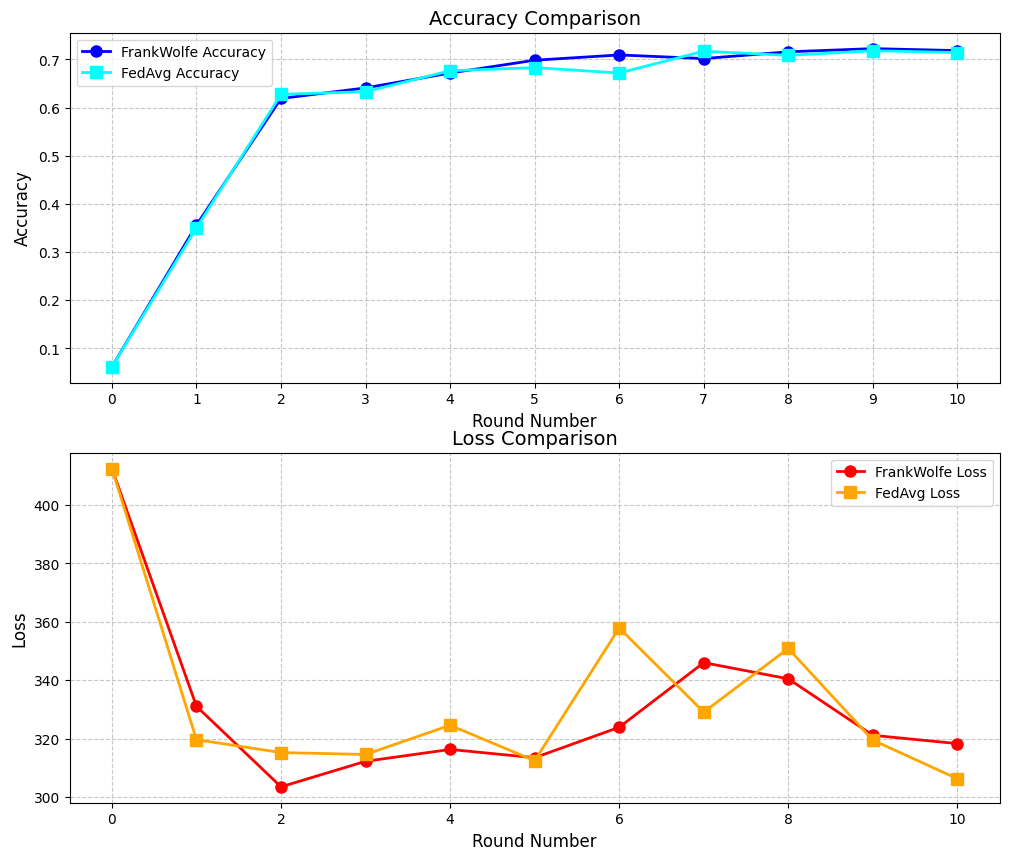

In [25]:
plot_metrics(hist, hist_fedavg)

In [26]:
# log(
#     INFO,
#     "Size of the list with the model parameters: %s",
#     len(parameters_for_each_round),
# )